<a href="https://colab.research.google.com/github/AneettaJoy/CBMNet-GVBlack/blob/main/CBMNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Set up Python 3.9 environment (required for compatibility with StyleGAN2-ADA and specific libraries)**

In [ ]:
# Update system packages and install Python 3.9
!sudo apt-get update -y
!sudo apt-get install python3.9 python3.9-distutils python3.9-dev -y
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!update-alternatives --config python3
!apt-get install python3.9-venv -y
!python3 -m ensurepip
!python3 -m pip install --upgrade pip setuptools wheel


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,679 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,237 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,767 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ub

**Import essential libraries for file handling, image processing (OpenCV), and JSON metadata operations**


In [ ]:
import os
import cv2
import glob
import json

**Install specific PyTorch (v1.7.1 with CUDA 11.0) and essential dependencies required for StyleGAN2-ADA training**


In [ ]:
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install scipy psutil numpy==1.23.5 pyspng ninja imageio-ffmpeg==0.4.3
!pip install requests click tqdm


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 152.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 136.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


**StyleGAN2ADA**

**Preprocess and Augment Dental X-ray Images for StyleGAN2-ADA Training** ------------------------------------------------------------------------------
This script loads grayscale X-ray images from Google Drive, converts them to
3-channel RGB, resizes them to 512x512 pixels, and performs augmentation
(rotation, flipping, brightness adjustment) to balance class sizes.
Key Steps:
- Converts grayscale images to RGB for compatibility with GAN models.
- Applies consistent resizing to 512x512.
- Balances dataset by augmenting minority classes to match the size of the majority class.
- Saves all processed and augmented images into a new output directory.

Useful for: Ensuring uniform size, format, and distribution of data before training a StyleGAN2-ADA model.


In [ ]:
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm

# Paths
input_path = "/content/drive/MyDrive/Finaldata"
output_path = "/content/drive/MyDrive/ProcessedFinaldata"
os.makedirs(output_path, exist_ok=True)

# Define augmentation (rotation, flipping, brightness adjustment)
augmentation = A.Compose([
    A.Rotate(limit=10, p=0.8),  # Small rotation (-10 to +10 degrees)
    A.HorizontalFlip(p=0.5),  # Flip with 50% probability
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.0, p=0.7),  # Adjust brightness <10%
])

# Define target image size
IMAGE_SIZE = 512

# Define number of images needed per class
target_class_size = 490  # Equalizing to Class 2 (largest class)

def process_images(class_name, input_folder, output_folder, num_augmentations=3):
    """
    Processes images: Augments (if needed), resizes to 512x512, converts to 3-channel RGB, and saves.
    """
    class_input_path = os.path.join(input_folder, class_name)
    class_output_path = os.path.join(output_folder, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    images = os.listdir(class_input_path)
    num_images = len(images)

    print(f"Processing {class_name}: Found {num_images} images.")

    for img_name in tqdm(images):
        img_path = os.path.join(class_input_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

        if img is None:
            print(f"Skipping {img_name}: Unable to read image.")
            continue

        # Convert grayscale to 3-channel RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Resize to 512x512
        img_rgb = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))

        # Convert to uint8 format before saving
        img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)

        # Save original (processed) image
        save_path = os.path.join(class_output_path, img_name)
        cv2.imwrite(save_path, img_rgb)

    # Augment for minority classes (Class 1 and Class 3)
    if num_images < target_class_size:
        print(f"Augmenting {class_name} to {target_class_size} images...")
        extra_needed = target_class_size - num_images

        augmented_count = 0
        while augmented_count < extra_needed:
            for img_name in images:
                img_path = os.path.join(class_input_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                img_rgb = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE))

                # Apply augmentation
                augmented_img = augmentation(image=img_rgb)["image"]

                # Save augmented image
                aug_save_path = os.path.join(class_output_path, f"{img_name.split('.')[0]}_aug_{augmented_count}.png")
                cv2.imwrite(aug_save_path, augmented_img)

                augmented_count += 1
                if augmented_count >= extra_needed:
                    break  # Stop augmentation once we reach the target

    print(f" {class_name} processed successfully! Total images: {len(os.listdir(class_output_path))}")

# Process each class
for class_name in ["Class1", "Class2", "Class3"]:
    process_images(class_name, input_path, output_path)

print(" All classes processed and saved in /drive/ProcessedFinaldata/")


Processing Class1: Found 409 images.


100%|██████████| 409/409 [00:21<00:00, 19.30it/s]


Augmenting Class1 to 490 images...
✅ Class1 processed successfully! Total images: 490
Processing Class2: Found 490 images.


100%|██████████| 490/490 [00:27<00:00, 17.82it/s]


✅ Class2 processed successfully! Total images: 490
Processing Class3: Found 205 images.


100%|██████████| 205/205 [00:10<00:00, 19.61it/s]


Augmenting Class3 to 490 images...
✅ Class3 processed successfully! Total images: 490
🎉 All classes processed and saved in /drive/ProcessedFinaldata/


**Creating `dataset.json` for StyleGAN2-ADA Training**

This step scans the processed image directory, retrieves class-wise image paths, assigns numeric labels to each class, and generates a `dataset.json` file. This JSON serves as the **input label mapping** for StyleGAN2-ADA, ensuring the model knows which images belong to which class during training.


In [ ]:
import json

# 2️ Define the processed dataset path in Drive
dataset_path = "/content/drive/MyDrive/ProcessedFinaldata"  # Change this if needed

# 3️ Check if dataset folder exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" Dataset folder not found at {dataset_path}. Check your path.")

# 4️ Get class names (subfolders inside dataset)
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

# 5️ Create label mapping (assigns index to each class)
class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

# 6️ Generate dataset.json with image-label mapping
labels = {}  # Dictionary to store image paths and their labels

for class_name, class_idx in class_to_index.items():
    class_folder = os.path.join(dataset_path, class_name)

    # Loop through all images in the class folder
    for img_name in os.listdir(class_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
            img_path = os.path.join(class_name, img_name)  # Relative path
            labels[img_path] = class_idx  # Assign label based on class name

# 7️ Save dataset.json inside the dataset folder
dataset_json = {"labels": labels}
json_path = os.path.join(dataset_path, "dataset.json")

with open(json_path, "w") as f:
    json.dump(dataset_json, f, indent=4)

print(f"dataset.json created successfully at {json_path}")
print(f"Classes found: {class_to_index}")
print(f"Total images labeled: {len(labels)}")


✅ dataset.json created successfully at /content/drive/MyDrive/ProcessedFinaldata/dataset.json
Classes found: {'Class1': 0, 'Class2': 1, 'Class3': 2}
Total images labeled: 1470


**Unzip and Set Up StyleGAN2-ADA Codebase**

This cell extracts the official `stylegan2-ada-pytorch` repository from Drive and changes the working directory to its root. This setup is essential to **access training scripts** and **configuration files** for launching GAN training.


In [ ]:
!unzip /content/drive/MyDrive/Stylegan/stylegan2-ada-pytorch-main.zip -d /content/
%cd /content/stylegan2-ada-pytorch-main



Archive:  /content/drive/MyDrive/Stylegan/stylegan2-ada-pytorch-main.zip
d72cc7d041b42ec8e806021a205ed9349f87c6a4
   creating: /content/stylegan2-ada-pytorch-main/
   creating: /content/stylegan2-ada-pytorch-main/.github/
   creating: /content/stylegan2-ada-pytorch-main/.github/ISSUE_TEMPLATE/
  inflating: /content/stylegan2-ada-pytorch-main/.github/ISSUE_TEMPLATE/bug_report.md  
  inflating: /content/stylegan2-ada-pytorch-main/.gitignore  
  inflating: /content/stylegan2-ada-pytorch-main/Dockerfile  
  inflating: /content/stylegan2-ada-pytorch-main/LICENSE.txt  
  inflating: /content/stylegan2-ada-pytorch-main/README.md  
  inflating: /content/stylegan2-ada-pytorch-main/calc_metrics.py  
  inflating: /content/stylegan2-ada-pytorch-main/dataset_tool.py  
   creating: /content/stylegan2-ada-pytorch-main/dnnlib/
  inflating: /content/stylegan2-ada-pytorch-main/dnnlib/__init__.py  
  inflating: /content/stylegan2-ada-pytorch-main/dnnlib/util.py  
  inflating: /content/stylegan2-ada-pytorc

**Launch StyleGAN2-ADA Training**

This command starts training StyleGAN2-ADA on the processed dataset using ADA (adaptive discriminator augmentation). It saves model checkpoints to Drive, applies automatic configuration (--cfg=auto), uses FID as the evaluation metric, and resumes training from the pre-trained FFHQ 512x512 model to accelerate convergence.

In [ ]:
!python train.py \
    --outdir="/content/drive/MyDrive/StyleGAN2_Checkpoints" \
    --data="/content/drive/MyDrive/ProcessedFinaldata" \
    --gpus=1 --snap=10 --kimg=2500 --mirror=1 --aug=ada --batch=32 \
    --cfg=auto --metrics=fid50k_full \
    --resume='ffhq512'


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/ProcessedFinaldata",
    "use_labels": false,
    "max_size": 1470,
    "xflip": true,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "

**Resume StyleGAN2-ADA Training from Custom Checkpoint**

This command resumes StyleGAN2-ADA training using a previously saved model checkpoint (network-snapshot-000080.pkl) from Drive. It continues training with the same settings—ADA augmentation, automatic config, FID evaluation, and saving progress every 10 snapshots—allowing the model to improve further without starting from scratch.

In [ ]:
!python train.py \
    --outdir="/content/drive/MyDrive/StyleGAN2_Checkpoints" \
    --data="/content/drive/MyDrive/ProcessedFinaldata" \
    --gpus=1 --snap=10 --kimg=2500 --mirror=1 --aug=ada --batch=32 \
    --cfg=auto --metrics=fid50k_full \
    --resume='/content/drive/MyDrive/StyleGAN2_Checkpoints/00002-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumeffhq512/network-snapshot-000080.pkl'


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/ProcessedFinaldata",
    "use_labels": false,
    "max_size": 1470,
    "xflip": true,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "

In [ ]:
!python train.py \
    --outdir="/content/drive/MyDrive/StyleGAN2_Checkpoints" \
    --data="/content/drive/MyDrive/ProcessedFinaldata" \
    --gpus=1 --snap=10 --kimg=2500 --mirror=1 --aug=ada --batch=32 \
    --cfg=auto --metrics=fid50k_full \
    --resume='/content/drive/MyDrive/StyleGAN2_Checkpoints/00004-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000040.pkl'


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/ProcessedFinaldata",
    "use_labels": false,
    "max_size": 1470,
    "xflip": true,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "

Training was stopped once the **Fréchet Inception Distance (FID) score reached 35**, indicating that the generated images had become sufficiently close to the real data distribution.**In the context of medical image synthesis (e.g., dental X-rays), an FID score below 50 is generally considered acceptable**, and scores below 40 often reflect visually realistic and high-quality outputs. Since further training showed diminishing returns and risked overfitting or mode collapse, early stopping at this point ensured efficient resource usage while preserving generation quality.

In [ ]:
!python train.py \
    --outdir="/content/drive/MyDrive/StyleGAN2_Checkpoints" \
    --data="/content/drive/MyDrive/ProcessedFinaldata" \
    --gpus=1 --snap=10 --kimg=2500 --mirror=1 --aug=ada --batch=32 \
    --cfg=auto --metrics=fid50k_full \
    --resume='/content/drive/MyDrive/StyleGAN2_Checkpoints/00005-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000080.pkl'


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/ProcessedFinaldata",
    "use_labels": false,
    "max_size": 1470,
    "xflip": true,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "

**Generate Synthetic Images Using Trained StyleGAN2-ADA Model**

This command uses the trained generator (saved at network-snapshot-000160.pkl) to synthesize 1001 images from random latent vectors (seeds=0-1000). The outputs are saved to the specified folder in Drive. This step helps visualize the quality and diversity of images learned by the model.

In [ ]:
!python generate.py --network="/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl" --seeds=0-1000 --outdir="/content/drive/MyDrive/output_images"


Loading networks from "/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl"...
Generating image for seed 0 (0/1001) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 1 (1/1001) ...
Generating image for seed 2 (2/1001) ...
Generating image for seed 3 (3/1001) ...
Generating image for seed 4 (4/1001) ...
Generating image for seed 5 (5/1001) ...
Generating image for seed 6 (6/1001) ...
Generating image for seed 7 (7/1001) ...
Generating image for seed 8 (8/1001) ...
Generating image for seed 9 (9/1001) ...
Generating image for seed 10 (10/1001) ...
Generating image for seed 11 (11/1001) ...
Generating image for seed 12 (12/1001) ...
Generating image for seed 13 (13/1001) ...
Generating image for seed 14 (14/1001) ...
Generating image for seed 15 (15/1001) ...
Generating image for seed 16 (16/1001) ...
Generating

**Continue Generating More Synthetic Images (Seeds 1001–2000)**

This command generates an additional set of 1000 synthetic images using the trained StyleGAN2-ADA model from the network-snapshot-000160.pkl checkpoint. It extends the dataset by producing new images from latent seeds 1001 to 2000, saved in the same output directory. This is useful for creating a larger pool of diverse synthetic samples for augmentation or downstream tasks.

In [ ]:
!python generate.py --network="/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl" --seeds=1001-2000 --outdir="/content/drive/MyDrive/output_images"


Loading networks from "/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl"...
Generating image for seed 1001 (0/1000) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 1002 (1/1000) ...
Generating image for seed 1003 (2/1000) ...
Generating image for seed 1004 (3/1000) ...
Generating image for seed 1005 (4/1000) ...
Generating image for seed 1006 (5/1000) ...
Generating image for seed 1007 (6/1000) ...
Generating image for seed 1008 (7/1000) ...
Generating image for seed 1009 (8/1000) ...
Generating image for seed 1010 (9/1000) ...
Generating image for seed 1011 (10/1000) ...
Generating image for seed 1012 (11/1000) ...
Generating image for seed 1013 (12/1000) ...
Generating image for seed 1014 (13/1000) ...
Generating image for seed 1015 (14/1000) ...
Generating image for seed 1016 (15/1000) ...
Generating 

**Justification for Generating More Synthetic Images**

We synthesized additional images because the initial batch (seeds 0–1000) included some low-quality or vague samples that were not suitable for training. Since the generation process was not class-conditional, the images did not have explicit class labels. Therefore, we needed a larger and more diverse pool of samples to manually curate and categorize the best-quality images into the three target classes. This ensured that only visually realistic and class-representative images were used for downstream tasks like augmentation or retraining.

In [ ]:
!python generate.py --network="/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl" --seeds=2001-3000 --outdir="/content/drive/MyDrive/output_images"


Loading networks from "/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl"...
Generating image for seed 2001 (0/1000) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 2002 (1/1000) ...
Generating image for seed 2003 (2/1000) ...
Generating image for seed 2004 (3/1000) ...
Generating image for seed 2005 (4/1000) ...
Generating image for seed 2006 (5/1000) ...
Generating image for seed 2007 (6/1000) ...
Generating image for seed 2008 (7/1000) ...
Generating image for seed 2009 (8/1000) ...
Generating image for seed 2010 (9/1000) ...
Generating image for seed 2011 (10/1000) ...
Generating image for seed 2012 (11/1000) ...
Generating image for seed 2013 (12/1000) ...
Generating image for seed 2014 (13/1000) ...
Generating image for seed 2015 (14/1000) ...
Generating image for seed 2016 (15/1000) ...
Generating 

In [ ]:
!python generate.py --network="/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl" --seeds=3001-4000 --outdir="/content/drive/MyDrive/output_images"


Loading networks from "/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl"...
Generating image for seed 3001 (0/1000) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 3002 (1/1000) ...
Generating image for seed 3003 (2/1000) ...
Generating image for seed 3004 (3/1000) ...
Generating image for seed 3005 (4/1000) ...
Generating image for seed 3006 (5/1000) ...
Generating image for seed 3007 (6/1000) ...
Generating image for seed 3008 (7/1000) ...
Generating image for seed 3009 (8/1000) ...
Generating image for seed 3010 (9/1000) ...
Generating image for seed 3011 (10/1000) ...
Generating image for seed 3012 (11/1000) ...
Generating image for seed 3013 (12/1000) ...
Generating image for seed 3014 (13/1000) ...
Generating image for seed 3015 (14/1000) ...
Generating image for seed 3016 (15/1000) ...
Generating 

In [ ]:
!python generate.py --network="/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl" --seeds=4001-5000 --outdir="/content/drive/MyDrive/output_images"


Loading networks from "/content/drive/MyDrive/StyleGAN2_Checkpoints/00006-ProcessedFinaldata-mirror-auto1-kimg2500-batch32-ada-resumecustom/network-snapshot-000160.pkl"...
Generating image for seed 4001 (0/1000) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 4002 (1/1000) ...
Generating image for seed 4003 (2/1000) ...
Generating image for seed 4004 (3/1000) ...
Generating image for seed 4005 (4/1000) ...
Generating image for seed 4006 (5/1000) ...
Generating image for seed 4007 (6/1000) ...
Generating image for seed 4008 (7/1000) ...
Generating image for seed 4009 (8/1000) ...
Generating image for seed 4010 (9/1000) ...
Generating image for seed 4011 (10/1000) ...
Generating image for seed 4012 (11/1000) ...
Generating image for seed 4013 (12/1000) ...
Generating image for seed 4014 (13/1000) ...
Generating image for seed 4015 (14/1000) ...
Generating image for seed 4016 (15/1000) ...
Generating 

**Preprocessing**

**Preprocessing Real + GAN-Synthesized Images for CBMNet Classification**

After StyleGAN2-ADA training, both real and synthetic dental X-ray images are combined into a unified dataset for downstream multi-class classification using CBMNet. This preprocessing step ensures all images (real + generated) are:

* Converted to 3-channel BGR format

* Resized to 224×224 for CBMNet input compatibility

* Enhanced using CLAHE for improved contrast

* Denoised with median blur to reduce GAN artifacts or scanner noise

* Normalized to float32 [0, 1] scale

Images are saved into class-wise folders under Train and Test, ready for training CBMNet on the augmented dataset.

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

# Define Paths
source_root = Path("/content/drive/MyDrive/DentalData")
target_root = Path("/content/drive/MyDrive/PreprocessedData")
target_size = (224, 224)

# Create Target Directory Structure
for split in ["Train", "Test"]:
    for cls in ["Class0", "Class1", "Class2"]:
        os.makedirs(target_root / split / cls, exist_ok=True)

# Preprocessing Function with Denoising
def preprocess_image(image_path, channel_counter):
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)

    if img is None:
        return None

    # Convert all to 3-channel BGR
    if len(img.shape) == 2:  # Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        channel_counter["grayscale"] += 1
    elif img.shape[-1] == 4:  # RGBA
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        channel_counter["rgba"] += 1
    elif img.shape[-1] == 3:  # RGB/BGR
        channel_counter["rgb"] += 1
    else:
        channel_counter["unknown"] += 1
        return None

    # Resize
    img = cv2.resize(img, target_size)

    # CLAHE
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    img = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

    # Apply median blur for artifact suppression
    img = cv2.medianBlur(img, 3)

    # Normalize
    img = img.astype(np.float32) / 255.0

    return img

# Batch Processing Function
def process_dataset(split="Train"):
    overall_counter = defaultdict(int)

    for cls in ["Class0", "Class1", "Class2"]:
        src_dir = source_root / split / cls
        dst_dir = target_root / split / cls
        channel_counter = defaultdict(int)

        for file in tqdm(os.listdir(src_dir), desc=f"{split}/{cls}"):
            src_path = src_dir / file
            dst_path = dst_dir / file

            try:
                img = preprocess_image(src_path, channel_counter)
                if img is not None:
                    img_uint8 = (img * 255).astype(np.uint8)
                    cv2.imwrite(str(dst_path.with_suffix('.png')), img_uint8)
            except Exception as e:
                print(f" Error processing {src_path.name}: {e}")

        # Print per-class summary
        print(f" {split}/{cls} Summary: {dict(channel_counter)}")
        for k, v in channel_counter.items():
            overall_counter[k] += v

    # Print split-wise total summary
    print(f" {split} Overall Summary: {dict(overall_counter)}")

# ✅ Run Preprocessing for Train and Test
process_dataset("Train")
process_dataset("Test")


Train/Class0: 100%|██████████| 480/480 [00:21<00:00, 22.79it/s]


📊 Train/Class0 Summary: {'rgba': 288, 'rgb': 192}


Train/Class1: 100%|██████████| 480/480 [00:17<00:00, 27.35it/s]


📊 Train/Class1 Summary: {'rgba': 370, 'rgb': 110}


Train/Class2: 100%|██████████| 480/480 [00:17<00:00, 27.28it/s]


📊 Train/Class2 Summary: {'grayscale': 249, 'rgba': 84, 'rgb': 147}
✅ Train Overall Summary: {'rgba': 742, 'rgb': 449, 'grayscale': 249}


Test/Class0: 100%|██████████| 120/120 [00:03<00:00, 30.22it/s]


📊 Test/Class0 Summary: {'rgba': 120}


Test/Class1: 100%|██████████| 120/120 [00:03<00:00, 31.33it/s]


📊 Test/Class1 Summary: {'rgba': 120}


Test/Class2: 100%|██████████| 120/120 [00:03<00:00, 30.42it/s]

📊 Test/Class2 Summary: {'rgba': 120}
✅ Test Overall Summary: {'rgba': 360}


**Verifying Image Channel Consistency in Preprocessed Dataset**
This step checks the channel format of all images in the preprocessed Train and Test sets (real + GAN-generated). It ensures that images are properly converted to 3-channel format (required by CBMNet and most CNNs). The script reports counts of:

* Grayscale (1-channel)

* BGR/RGB (3-channel)

* RGBA (4-channel)

* Any unknown formats

This validation helps catch preprocessing issues and confirms readiness for input into the classification model.

In [ ]:
import cv2
import os
from pathlib import Path
from collections import defaultdict

# Define your preprocessed root path
preprocessed_root = Path("/content/drive/MyDrive/PreprocessedData")

# Channel counter dictionary
channel_counts = defaultdict(int)

# Loop over Train and Test sets
for split in ["Train", "Test"]:
    print(f"\n Checking {split} set:")
    for cls in ["Class0", "Class1", "Class2"]:
        folder = preprocessed_root / split / cls
        cls_counter = defaultdict(int)

        for file in os.listdir(folder):
            path = folder / file
            img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)

            if img is None:
                print(f" Cannot load image: {file}")
                continue

            if len(img.shape) == 2:
                cls_counter["1-channel"] += 1
            elif img.shape[-1] == 3:
                cls_counter["3-channel"] += 1
            elif img.shape[-1] == 4:
                cls_counter["4-channel"] += 1
            else:
                cls_counter["unknown"] += 1

        print(f" {split}/{cls}: {dict(cls_counter)}")

        # Update global count
        for k, v in cls_counter.items():
            channel_counts[k] += v

# Summary
print(f"\n Overall Summary: {dict(channel_counts)}")



🔍 Checking Train set:
📁 Train/Class0: {'3-channel': 480}
📁 Train/Class1: {'3-channel': 480}
📁 Train/Class2: {'3-channel': 480}

🔍 Checking Test set:
📁 Test/Class0: {'3-channel': 120}
📁 Test/Class1: {'3-channel': 120}
📁 Test/Class2: {'3-channel': 120}

✅ Overall Summary: {'3-channel': 1800}


**BRISQUE Quality Assessment of Real Images (Train Set)**
This step evaluates the perceptual quality of real dental X-ray images using the BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator) metric, which quantifies distortions without needing a reference image.

Key actions:

* Loads grayscale images from each class folder

* Computes BRISQUE score using the piq PyTorch library

* Stores and summarizes scores by class

* Visualizes quality variations with boxplots and histograms

This helps assess baseline quality before introducing synthetic GAN images, ensuring that poor-quality real samples don’t bias the classification model.

Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.0/brisque_svm_weights.pt" to /root/.cache/torch/hub/checkpoints/brisque_svm_weights.pt
100%|██████████| 112k/112k [00:00<00:00, 4.92MB/s]



📊 BRISQUE Score Summary:
         count       mean       std        min        25%        50%  \
Class                                                                 
Class0  480.0  30.605329  3.859959  18.938660  27.858948  30.539734   
Class1  480.0  31.193345  4.890542  19.473816  27.676819  30.966492   
Class2  480.0  33.931297  5.345800  21.856628  30.081726  33.591980   

              75%        max  
Class                         
Class0  33.372864  42.239441  
Class1  34.326355  48.092468  
Class2  37.651794  47.365906  


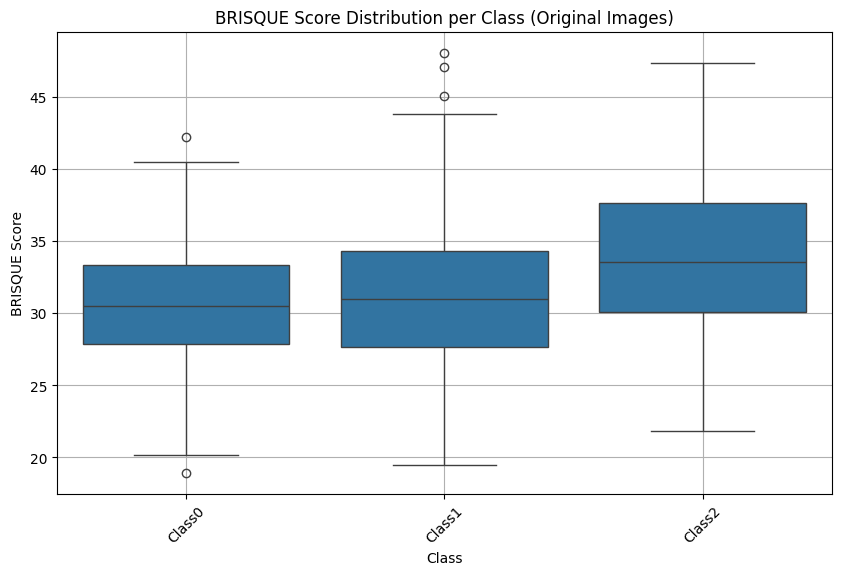

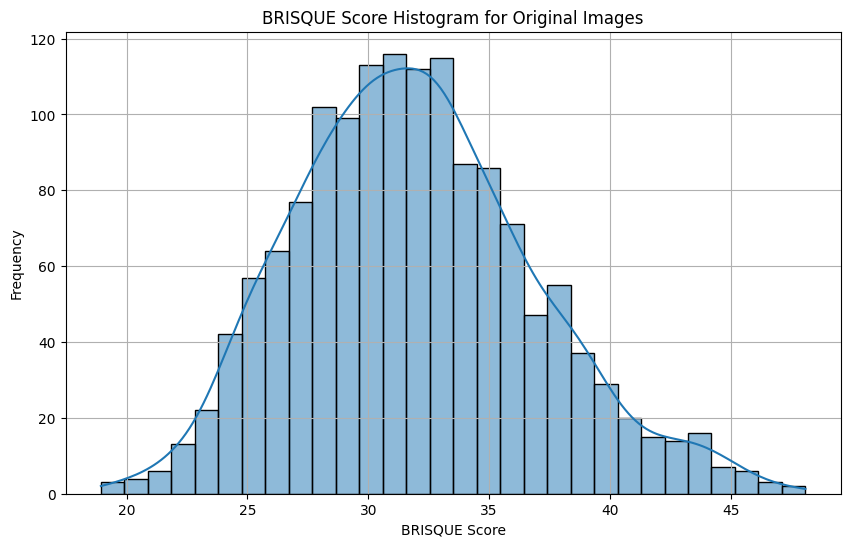

In [ ]:
import os
import cv2
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import piq  # PyTorch Image Quality Library



# 🔹 Define the base folder containing original images
base_folder = "/content/drive/MyDrive/PreprocessedData/Train"

# 🔹 List of class folders
class_folders = ["Class0", "Class1", "Class2"]

# 🔹 Store BRISQUE scores for all images
brisque_scores = []

# 🔹 Loop through each class folder
for class_name in class_folders:
    class_path = os.path.join(base_folder, class_name)

    # Get list of images
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image
    for image_name in image_files:
        img_path = os.path.join(class_path, image_name)

        # Read image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f" Error loading {image_name}")
            continue

        # Convert to tensor and normalize
        img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float() / 255.0

        # Compute BRISQUE Score using PyTorch
        brisque_score = piq.brisque(img_tensor, data_range=1.0)

        # Store results
        brisque_scores.append({"Class": class_name, "Image": image_name, "BRISQUE Score": brisque_score.item()})

# 🔹 Convert to DataFrame
df = pd.DataFrame(brisque_scores)


# 🔹 Generate Descriptive Summary
summary = df.groupby("Class")["BRISQUE Score"].describe()
print("\n BRISQUE Score Summary:\n", summary)

# 🔹 Visualization: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Class", y="BRISQUE Score", data=df)
plt.title("BRISQUE Score Distribution per Class (Original Images)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 🔹 Visualization: Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["BRISQUE Score"], bins=30, kde=True)
plt.title("BRISQUE Score Histogram for Original Images")
plt.xlabel("BRISQUE Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()


**BRISQUE Quality Assessment of Real Images (Test Set)**


📊 BRISQUE Score Summary:
         count       mean       std        min        25%        50%  \
Class                                                                 
Class0  120.0  30.405868  4.304753  19.630066  27.369568  30.200623   
Class1  120.0  32.199491  4.827128  19.574402  29.620789  32.057556   
Class2  120.0  33.270780  4.941783  22.772644  30.018372  32.752625   

              75%        max  
Class                         
Class0  32.957336  43.240906  
Class1  35.207703  49.438660  
Class2  36.336609  46.327332  


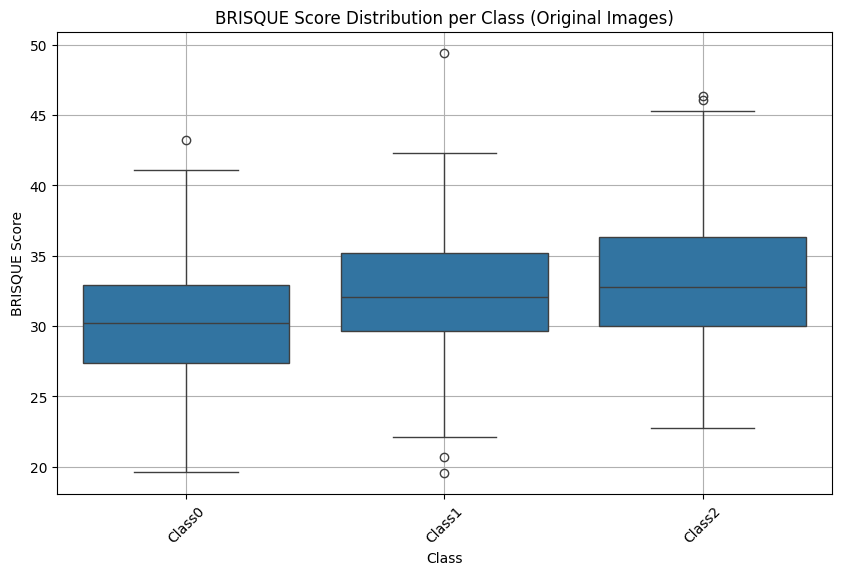

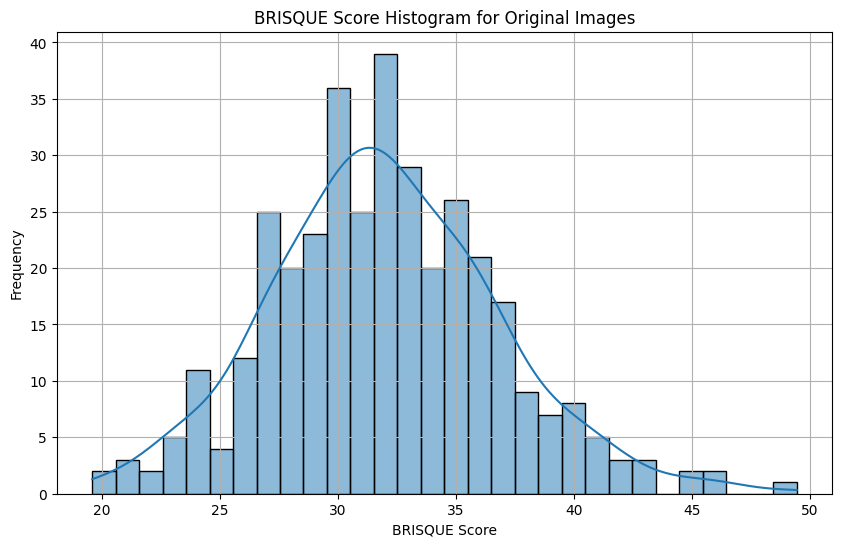

In [ ]:
import os
import cv2
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import piq  # PyTorch Image Quality Library



#  Define the base folder containing original images
base_folder = "/content/drive/MyDrive/PreprocessedData/Test"

#  List of class folders
class_folders = ["Class0", "Class1", "Class2"]

#  Store BRISQUE scores for all images
brisque_scores = []

# Loop through each class folder
for class_name in class_folders:
    class_path = os.path.join(base_folder, class_name)

    # Get list of images
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Process each image
    for image_name in image_files:
        img_path = os.path.join(class_path, image_name)

        # Read image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f" Error loading {image_name}")
            continue

        # Convert to tensor and normalize
        img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).float() / 255.0

        # Compute BRISQUE Score using PyTorch
        brisque_score = piq.brisque(img_tensor, data_range=1.0)

        # Store results
        brisque_scores.append({"Class": class_name, "Image": image_name, "BRISQUE Score": brisque_score.item()})

#  Convert to DataFrame
df = pd.DataFrame(brisque_scores)


#  Generate Descriptive Summary
summary = df.groupby("Class")["BRISQUE Score"].describe()
print("\n BRISQUE Score Summary:\n", summary)

#  Visualization: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Class", y="BRISQUE Score", data=df)
plt.title("BRISQUE Score Distribution per Class (Original Images)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

#  Visualization: Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["BRISQUE Score"], bins=30, kde=True)
plt.title("BRISQUE Score Histogram for Original Images")
plt.xlabel("BRISQUE Score")
plt.ylabel("Frequency")
plt.grid()
plt.show()


**CBMNet Classifier**

**Install Required Libraries for Classification Pipeline**
This command installs key dependencies used in the classification workflow:

* albumentations: for advanced image augmentations

* opencv-python: for image loading, resizing, and preprocessing

* mealpy: for metaheuristic-based hyperparameter optimization (e.g., PSO, GWO)

These libraries are essential for building a robust and optimized training pipeline for CBMNet.

In [ ]:
!pip install albumentations opencv-python mealpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 117.6 MB/s eta 0:00:00


This section builds a full training pipeline using a ConvNeXtTiny backbone enhanced with CBAM + MSAM attention blocks, optimized for multi-class classification of preprocessed dental X-rays (real + StyleGAN2-ADA generated).

**Key Components:**
* Albumentations for advanced data augmentation.

* CBAM + MSAM block to capture spatial + channel attention for improved feature learning.

* Focal Loss to handle class imbalance with tunable focusing and weighting factors.

* CosineDecayRestarts learning rate schedule for cyclical optimization.

* AdamW optimizer with L2 regularization and weight decay.

**Hyperparameter Tuning:**
We use **Particle Swarm Optimization (PSO)** from the mealpy library to tune key hyperparameters:

* Initial learning rate

* Weight decay

* Dropout rates

* L2 regularization strength

* Cosine schedule's first decay step

The goal is to maximize validation accuracy while preventing overfitting. The best configuration found by PSO is then used to finalize the model setup for training and evaluation.

In [ ]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A

from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Reshape, Dense, Activation, Multiply, Add,
                                     Conv2D, Concatenate, Lambda, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.losses import Loss
from mealpy.utils.space import FloatVar, IntegerVar
from mealpy.utils.problem import Problem
from mealpy.swarm_based import PSO


# ───────────────────────────────────────────────────────────────
# 1) Configuration & Paths
# ───────────────────────────────────────────────────────────────
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
VAL_SPLIT   = 0.2
SEED        = 42

TRAIN_DIR = Path("/content/drive/MyDrive/PreprocessedData/Train")
TEST_DIR  = Path("/content/drive/MyDrive/PreprocessedData/Test")

# ───────────────────────────────────────────────────────────────
# 2) Load Dataset
# ───────────────────────────────────────────────────────────────
def make_df(folder: Path):
    data = []
    for cls in os.listdir(folder):
        for f in os.listdir(folder/cls):
            data.append({"filepath": str(folder/cls/f), "label": cls})
    return pd.DataFrame(data)

df = make_df(TRAIN_DIR)
train_df, val_df = train_test_split(df, test_size=VAL_SPLIT,
                                     stratify=df["label"], random_state=SEED)
test_df = make_df(TEST_DIR)

labels     = sorted(train_df["label"].unique())
label_map  = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, dtype=np.float32)
    v[label_map[lbl]] = 1.0
    return v

for df_ in [train_df, val_df, test_df]:
    df_["oh"] = df_["label"].map(to_onehot)

train_paths, train_labels = train_df["filepath"].values, np.stack(train_df["oh"].values)
val_paths,   val_labels   = val_df["filepath"].values,   np.stack(val_df["oh"].values)
test_paths,  test_labels  = test_df["filepath"].values,  np.stack(test_df["oh"].values)

# ───────────────────────────────────────────────────────────────
# 3) Albumentations + tf.data
# ───────────────────────────────────────────────────────────────
train_tf = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    # Replacing ShiftScaleRotate with Affine
    A.Affine(
        scale=(0.9, 1.1),
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-15, 15),
        shear=(-5, 5),
        p=0.5
    ),

    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),

    # Correct CoarseDropout
   A.CoarseDropout(
    max_holes=8,
    max_height=16,
    max_width=16,
    fill_value=0,
    p=0.3
   ),

    # Use GaussianBlur instead of deprecated GaussNoise
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),

    A.MedianBlur(blur_limit=3, p=0.2),
    A.MotionBlur(blur_limit=3, p=0.2),

    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.2),
], p=1.0)



val_tf = A.Compose([A.Resize(*IMG_SIZE)])

def mapper(path, label, aug):
    def _parse(p, l):
        p = p.decode()
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = aug(image=img)["image"]
        img = preprocess_input(img)
        return img.astype(np.float32), l.astype(np.float32)
    img, lbl = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3])
    lbl.set_shape([NUM_CLASSES])
    return img, lbl

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_paths, train_labels, train_tf, shuffle=True)
val_ds   = make_ds(val_paths, val_labels, val_tf)
test_ds  = make_ds(test_paths, test_labels, val_tf)

# ───────────────────────────────────────────────────────────────
# 4) CBAM + MSAM Block
# ───────────────────────────────────────────────────────────────
def cbam_msam_block(x, ratio=8):
    ch = x.shape[-1]
    avg = GlobalAveragePooling2D()(x)
    mx  = GlobalMaxPooling2D()(x)
    d1, d2 = Dense(ch//ratio, activation="relu"), Dense(ch)
    att = Activation("sigmoid")(Add()([d2(d1(avg)), d2(d1(mx))]))
    att = Reshape((1, 1, ch))(att)
    x1 = Multiply()([x, att])

    ap = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x1)
    mp = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x1)
    sp = Concatenate(axis=-1)([ap, mp])
    sa = Conv2D(1, 7, padding="same", activation="sigmoid")(sp)
    x2 = Multiply()([x1, sa])

    merged = Add()([avg, mx])
    merged = Reshape((1, 1, ch))(merged)
    msam = Conv2D(ch, 1, activation="sigmoid")(merged)

    return Multiply()([x2, msam])



class FocalLoss(Loss):
    def __init__(self, gamma=1.5, alpha=0.25, from_logits=False, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = self.alpha * tf.pow(1 - y_pred, self.gamma)
        loss = weights * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


# ───────────────────────────────────────────────────────────────
# 5) Model Builder
# ───────────────────────────────────────────────────────────────
def build_model(hp):
    base = ConvNeXtTiny(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
    x = cbam_msam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, activation="relu", kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(base.input, out)

    sched = CosineDecayRestarts(
        initial_learning_rate=hp["init_lr"],
        first_decay_steps=int(hp["fds"]), t_mul=2.0, m_mul=1.0, alpha=1e-6
    )
    opt = AdamW(learning_rate=sched, weight_decay=hp["wd"])
    loss_fn = FocalLoss(gamma=1.5, alpha=0.25, from_logits=False)
    model.compile(opt, loss_fn, metrics=["accuracy"])

    return model

    # ... [existing code remains unchanged above]

# ───────────────────────────────────────────────────────────────
# 7) PSO-Based Hyperparameter Tuning for Focal Loss
# ───────────────────────────────────────────────────────────────

def fitness_fn(sol):
    hp = {
        "init_lr": sol[0],
        "wd": sol[1],
        "d1": sol[2],
        "d2": sol[3],
        "fds": sol[4],
        "l2": sol[5]
    }
    tf.keras.backend.clear_session()
    model = build_model(hp)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=0,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    best_val_acc = max(history.history["val_accuracy"])
    cost = 1.0 - best_val_acc
    if best_val_acc > fitness_fn.best:
        fitness_fn.best = best_val_acc
        print(f"\n New Best Val Acc: {best_val_acc:.4f} with HPs: {hp}")
    return cost

fitness_fn.best = 0.0

class FocalTuningProblem(Problem):
    def __init__(self):
        bounds = [
            FloatVar(1e-5, 5e-4),   # init_lr
            FloatVar(1e-6, 1e-4),   # wd
            FloatVar(0.1, 0.5),     # d1
            FloatVar(0.1, 0.5),     # d2
            IntegerVar(5, 20),      # fds
            FloatVar(1e-6, 1e-3)   # l2
          ]
        super().__init__(bounds=bounds, minmax="min", verbose=True)

    def obj_func(self, solution):
        return fitness_fn(solution)

# Run PSO
problem = FocalTuningProblem()
solver = PSO.OriginalPSO(epoch=15, pop_size=6)
best_sol, best_fit = solver.solve(problem)

# Print final result
print("\n Best Hyperparameters from PSO:")
print(f"init_lr = {best_sol[0]:.6f}")
print(f"weight_decay = {best_sol[1]:.6f}")
print(f"dropout1 = {best_sol[2]:.2f}, dropout2 = {best_sol[3]:.2f}")
print(f"first_decay_steps = {int(best_sol[4])}")
print(f"l2_reg = {best_sol[5]:.6f}")
print(f"epochs = {int(best_sol[6])}, patience = {int(best_sol[7])}")


<ipython-input-3-57080c0d8a4d>:90: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
INFO:mealpy.swarm_based.PSO.OriginalPSO:Solving single objective optimization problem.



💎 New Best Val Acc: 0.9306 with HPs: {'init_lr': np.float64(0.0004910040373905444), 'wd': np.float64(5.044492144052354e-05), 'd1': np.float64(0.3945836556275105), 'd2': np.float64(0.44529510637476266), 'fds': np.float64(14.0), 'l2': np.float64(0.0005715224173736598)}

💎 New Best Val Acc: 0.9410 with HPs: {'init_lr': np.float64(0.00022753916030064674), 'wd': np.float64(4.6729343651529216e-05), 'd1': np.float64(0.10898448815227901), 'd2': np.float64(0.16005653742715564), 'fds': np.float64(7.0), 'l2': np.float64(0.0008708726993313023)}


INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 1, Current best: 0.059027791023254395, Global best: 0.059027791023254395, Runtime: 1029.43847 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 2, Current best: 0.059027791023254395, Global best: 0.059027791023254395, Runtime: 1041.66610 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 3, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1057.34897 seconds



💎 New Best Val Acc: 0.9444 with HPs: {'init_lr': np.float64(0.0001111530157634727), 'wd': np.float64(3.322206281788534e-05), 'd1': np.float64(0.4220298329342723), 'd2': np.float64(0.134682567208889), 'fds': np.float64(7.62626606874413), 'l2': np.float64(0.0009823013966244155)}


INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 4, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1066.34228 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 5, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1081.23489 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 6, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1084.46716 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 7, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1102.67697 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 8, Current best: 0.05555558204650879, Global best: 0.05555558204650879, Runtime: 1104.54393 seconds



💎 New Best Val Acc: 0.9549 with HPs: {'init_lr': np.float64(0.0003930434735585379), 'wd': np.float64(1.8392558832968022e-05), 'd1': np.float64(0.42122483550873685), 'd2': np.float64(0.16436263855893496), 'fds': np.float64(7.002203290549747), 'l2': np.float64(0.000998442519555421)}


INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 9, Current best: 0.0451388955116272, Global best: 0.0451388955116272, Runtime: 1123.49104 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 10, Current best: 0.0451388955116272, Global best: 0.0451388955116272, Runtime: 1132.85083 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 11, Current best: 0.0451388955116272, Global best: 0.0451388955116272, Runtime: 1144.04094 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 12, Current best: 0.0451388955116272, Global best: 0.0451388955116272, Runtime: 1167.84408 seconds


**Best Hyperparameters Identified via PSO**
After 9 epochs of Particle Swarm Optimization (PSO), the model achieved a validation accuracy of 95.49%, corresponding to a cost of 0.0451 (1 - accuracy). The following hyperparameters yielded the best performance:

1. Initial Learning Rate: 3.93e-4

2. Weight Decay: 1.84e-5

3. Dropout Rate 1: 0.421

4. Dropout Rate 2: 0.164

5. First Decay Step (Cosine Scheduler): 7

6. L2 Regularization Strength: 9.98e-4

This configuration will be used to finalize training of the CBMNet-enhanced ConvNeXtTiny model.


**Final Classification: ConvNeXtTiny + CBAM + MSAM with 5-Fold Cross-Validation and Test Evaluation**

This section implements the **final classification pipeline** using a hybrid ConvNeXtTiny model enhanced with **CBAM + MSAM attention** for dental X-ray classification across three classes.
Key Steps Covered:
1. **Data Augmentation & Preprocessing**

* Uses **Albumentations** to perform strong augmentations for training and light transforms for validation and test-time augmentation (TTA).
* Normalizes images using `ConvNeXtTiny`'s preprocessing function.

2. **Model Architecture**

* Base model: `ConvNeXtTiny` pretrained on ImageNet.
* Attention modules: **CBAM (Channel + Spatial)** + **MSAM (Max-Avg Spatial Attention Module)**.
* Custom classifier head with L2 regularization and dropout.

3. **Cross-Validation Training**

* Performs **5-fold Stratified Cross-Validation** on the training set to assess model stability.
* Reports fold-wise validation accuracy and mean ± standard deviation.

4. **Full Model Training + Test Evaluation**

* Retrains the model on the **entire training set** using best PSO-found hyperparameters.
* Evaluates performance on held-out **test set**, both:

  * **Without TTA (plain test accuracy)**
  * **With TTA (average prediction across 5 augmented rounds)**

5. **Reporting**

* Prints final accuracy metrics and a detailed **classification report** including precision, recall, and F1-score for each class.

This full pipeline ensures the model is thoroughly validated and generalizes well to unseen data, leveraging both real and GAN-generated images for robust performance.




In [ ]:
# ───────────────────────────────────────────────────────────────
# ConvNeXtTiny + CBAM + MSAM   •   5-fold CV + Test Evaluation
# ───────────────────────────────────────────────────────────────

import os, cv2, numpy as np, pandas as pd, tensorflow as tf, albumentations as A
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Reshape, Dense, Activation, Multiply, Add,
                                     Conv2D, Concatenate, Lambda, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2

# ───────────────────────────────────────────────────────────────
# 1) Config
# ───────────────────────────────────────────────────────────────
IMG_SIZE      = (224, 224)
BATCH_SIZE    = 32
K_FOLDS       = 5
EPOCHS        = 50
PATIENCE      = 10
SEED          = 42

TRAIN_DIR = Path("/content/drive/MyDrive/PreprocessedData/Train")
TEST_DIR  = Path("/content/drive/MyDrive/PreprocessedData/Test")

best_hp = {
    "init_lr": 0.0003930434735585379,
    "wd": 1.8392558832968022e-05,
    "d1":0.42122483550873685,
    "d2":0.16436263855893496,
    "fds": 7,
    "l2": 0.000998442519555421,
}

# ───────────────────────────────────────────────────────────────
# 2) Albumentations
# ───────────────────────────────────────────────────────────────
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.Affine(scale=(0.9,1.1), translate_percent={"x":(-.05,.05),"y":(-.05,.05)},
             rotate=(-15,15), shear=(-5,5), p=0.5),
    A.RandomBrightnessContrast(0.2,0.2, p=0.4),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.GaussianBlur((3,5), p=0.3),
    A.MedianBlur(3, p=0.2), A.MotionBlur(3, p=0.2),
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.2),
], p=1.0)

val_tf  = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)
tta_tf  = A.Compose([A.Resize(*IMG_SIZE), A.HorizontalFlip(0.2),
                     A.RandomBrightnessContrast(0.1,0.1, p=0.2)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE,3]); lab.set_shape([NUM_CLASSES])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x,y: mapper(x,y,aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ───────────────────────────────────────────────────────────────
# 3) Dataset
# ───────────────────────────────────────────────────────────────
def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df   = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels      = sorted(df.label.unique())
label_map   = {c:i for i,c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]]=1; return v

df["oh"]   = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths  = test.filepath.values
test_labels = np.stack(test.oh.values)

# ───────────────────────────────────────────────────────────────
# 4) Blocks & Loss
# ───────────────────────────────────────────────────────────────
def cbam_msam_block(x, ratio=8):
    ch, avg, mx = x.shape[-1], GlobalAveragePooling2D()(x), GlobalMaxPooling2D()(x)
    d1,d2 = Dense(ch//ratio, 'relu'), Dense(ch)
    att   = Activation("sigmoid")(Add()([d2(d1(avg)), d2(d1(mx))]))
    x1    = Multiply()([x, Reshape((1,1,ch))(att)])
    ap, mp = Lambda(lambda z: tf.reduce_mean(z,-1,True))(x1), Lambda(lambda z: tf.reduce_max(z,-1,True))(x1)
    sa    = Conv2D(1,7,padding="same",activation="sigmoid")(Concatenate()([ap,mp]))
    x2    = Multiply()([x1, sa])
    msam  = Conv2D(ch,1,activation="sigmoid")(Reshape((1,1,ch))(Add()([avg,mx])))
    return Multiply()([x2, msam])

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=1.5, alpha=0.25, from_logits=False, **kw):
        super().__init__(**kw); self.g, self.a, self.logit=gamma,alpha,from_logits
    def call(self, y_true, y_pred):
        if self.logit: y_pred = tf.nn.softmax(y_pred,-1)
        eps=1e-7; y_pred=tf.clip_by_value(y_pred,eps,1-eps)
        ce=-y_true*tf.math.log(y_pred)
        loss=self.a*tf.pow(1-y_pred,self.g)*ce
        return tf.reduce_sum(loss,-1)

def build_model(hp):
    base = ConvNeXtTiny(include_top=False, weights='imagenet',
                        input_shape=(*IMG_SIZE,3))
    x = cbam_msam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256,'relu',kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES,'softmax')(x)
    m = Model(base.input,out)
    sched = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    m.compile(AdamW(sched, weight_decay=hp["wd"]),
              FocalLoss(), metrics=['accuracy'])
    return m

# ───────────────────────────────────────────────────────────────
# 5) 5-Fold CV loop
# ───────────────────────────────────────────────────────────────
cv = StratifiedKFold(K_FOLDS, shuffle=True, random_state=SEED)
fold_acc = []

for fold,(train_idx,val_idx) in enumerate(cv.split(X, df.label.values), 1):
    print(f"\n━━ FOLD {fold}/{K_FOLDS} ━━")
    tr_ds = make_ds(X[train_idx], y[train_idx], train_tf, shuffle=True)
    va_ds = make_ds(X[val_idx],   y[val_idx],   val_tf)

    model = build_model(best_hp)
    ckpt  = f"fold{fold}.h5"
    model.fit(tr_ds, validation_data=va_ds,
              epochs=EPOCHS,
              callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                         ModelCheckpoint(ckpt,"val_accuracy",save_best_only=True,mode="max")],
              verbose=1)
    model.load_weights(ckpt)
    val_acc = model.evaluate(va_ds,verbose=0)[1]
    fold_acc.append(val_acc)
    print(f"FOLD {fold} val_acc: {val_acc:.4f}")

print("\n━━ CV summary ━━")
print("Fold acc:", [f"{a:.4f}" for a in fold_acc])
print(f"Mean ± std:  {np.mean(fold_acc):.4f} ± {np.std(fold_acc):.4f}")

# ───────────────────────────────────────────────────────────────
# 6) Train on full training data, evaluate on held-out test
# ───────────────────────────────────────────────────────────────
full_train_ds = make_ds(X, y, train_tf, shuffle=True)
val_ds_dummy  = make_ds(X[:BATCH_SIZE], y[:BATCH_SIZE], val_tf)  # tiny dummy for ES

model = build_model(best_hp)
model.fit(full_train_ds, validation_data=val_ds_dummy,
          epochs=EPOCHS,
          callbacks=[EarlyStopping( patience=PATIENCE, restore_best_weights=True),
                     ModelCheckpoint("final_full.h5", "accuracy",
                                     save_best_only=True, mode="max")],
          verbose=1)

model.load_weights("final_full.h5")
plain_test_acc = model.evaluate(make_ds(test_paths, test_labels, val_tf), verbose=0)[1]

# TTA
def predict_tta(m, rounds=5):
    preds=[]
    for _ in range(rounds):
        ds=tf.data.Dataset.from_tensor_slices((test_paths,test_labels))
        ds=ds.map(lambda p,l: mapper(p,l,tta_tf), num_parallel_calls=tf.data.AUTOTUNE)
        preds.append(m.predict(ds.batch(BATCH_SIZE),verbose=0))
    return np.mean(preds,axis=0)

tta_preds = predict_tta(model, rounds=5)
y_true    = np.argmax(test_labels,1)
y_pred    = np.argmax(tta_preds,1)
tta_acc   = accuracy_score(y_true, y_pred)

print("\n━━ Test results ━━")
print(f"Plain test acc : {plain_test_acc:.4f}")
print(f"TTA   test acc : {tta_acc:.4f}")
print(classification_report(y_true, y_pred, target_names=labels))


<ipython-input-4-e5f90de1c8e4>:49: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),



━━ FOLD 1/5 ━━
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4061 - loss: 0.5049

36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 682ms/step - accuracy: 0.4090 - loss: 0.5039 - val_accuracy: 0.7153 - val_loss: 0.3706
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6881 - loss: 0.3689

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 486ms/step - accuracy: 0.6881 - loss: 0.3685 - val_accuracy: 0.8021 - val_loss: 0.2939
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - accuracy: 0.7883 - loss: 0.2888 - val_accuracy: 0.7882 - val_loss: 0.2788
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.7976 - loss: 0.2529 - val_accuracy: 0.7951 - val_loss: 0.2084
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8232 - loss: 0.2027

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.8237 - loss: 0.2024 - val_accuracy: 0.9028 - val_loss: 0.1659
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9027 - loss: 0.1678

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9029 - loss: 0.1677 - val_accuracy: 0.9167 - val_loss: 0.1631
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.8792 - loss: 0.1601 - val_accuracy: 0.8785 - val_loss: 0.1337
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.8885 - loss: 0.1252 - val_accuracy: 0.8819 - val_loss: 0.1072
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8964 - loss: 0.1023

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.8971 - loss: 0.1022 - val_accuracy: 0.9236 - val_loss: 0.0934
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.9531 - loss: 0.0825 - val_accuracy: 0.9097 - val_loss: 0.0986
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9551 - loss: 0.0736

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9554 - loss: 0.0735 - val_accuracy: 0.9306 - val_loss: 0.0860
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9685 - loss: 0.0696 - val_accuracy: 0.9306 - val_loss: 0.0856
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9749 - loss: 0.0682 - val_accuracy: 0.9271 - val_loss: 0.0775
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9472 - loss: 0.0642 - val_accuracy: 0.8854 - val_loss: 0.0733
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9314 - loss: 0.0548 - val_accuracy: 0.8993 - val_loss: 0.0721
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9526 - loss: 0.0482 - val_accuracy: 0.8993 - val_loss: 0.0548
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9514 - loss: 0.0439 - val_accuracy: 0.9097 - val_loss: 0.0517
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9736 - loss: 0.0340 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 483ms/step - accuracy: 0.9883 - loss: 0.0255 - val_accuracy: 0.9340 - val_loss: 0.0543
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9901 - loss: 0.0246 - val_accuracy: 0.9201 - val_loss: 0.0557
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9803 - loss: 0.0263 - val_accuracy: 0.9306 - val_loss: 0.0493
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9933 - loss: 0.0231

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.9932 - loss: 0.0231 - val_accuracy: 0.9375 - val_loss: 0.0488
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9884 - loss: 0.0228 - val_accuracy: 0.9375 - val_loss: 0.0487
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9851 - loss: 0.0239 - val_accuracy: 0.8993 - val_loss: 0.0675
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9603 - loss: 0.0308 - val_accuracy: 0.8958 - val_loss: 0.0479
Epoch 27/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9621 - loss: 0.0280 - val_accuracy: 0.9167 - val_loss: 0.0433
Epoch 28/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9466 - loss: 0.0278 - val_accuracy: 0.8819 - val_loss: 0.0459
Epoch 29/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9684 - loss: 0.0231 - val_accuracy: 0.9201 - val_loss: 0.0408
Epoch 30/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9622 - loss: 0.0197 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 97s 660ms/step - accuracy: 0.3294 - loss: 0.5015 - val_accuracy: 0.4549 - val_loss: 0.4092
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4491 - loss: 0.3926

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - accuracy: 0.4507 - loss: 0.3918 - val_accuracy: 0.7292 - val_loss: 0.2654
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7079 - loss: 0.2537

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 490ms/step - accuracy: 0.7085 - loss: 0.2534 - val_accuracy: 0.7708 - val_loss: 0.2153
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7278 - loss: 0.2159

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.7291 - loss: 0.2152 - val_accuracy: 0.8576 - val_loss: 0.1512
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8160 - loss: 0.1497

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 486ms/step - accuracy: 0.8166 - loss: 0.1494 - val_accuracy: 0.8611 - val_loss: 0.1284
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8951 - loss: 0.1190

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - accuracy: 0.8952 - loss: 0.1190 - val_accuracy: 0.8819 - val_loss: 0.1223
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.8261 - loss: 0.1213 - val_accuracy: 0.8646 - val_loss: 0.0926
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.8767 - loss: 0.0838 - val_accuracy: 0.8681 - val_loss: 0.0828
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.8608 - loss: 0.0742 - val_accuracy: 0.8750 - val_loss: 0.0712
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9221 - loss: 0.0558

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - accuracy: 0.9225 - loss: 0.0557 - val_accuracy: 0.8889 - val_loss: 0.0675
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9478 - loss: 0.0447

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.9478 - loss: 0.0447 - val_accuracy: 0.8924 - val_loss: 0.0651
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9463 - loss: 0.0436 - val_accuracy: 0.8819 - val_loss: 0.0650
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9526 - loss: 0.0408 - val_accuracy: 0.8854 - val_loss: 0.0557
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9312 - loss: 0.0396 - val_accuracy: 0.8889 - val_loss: 0.0605
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9394 - loss: 0.0360 - val_accuracy: 0.8785 - val_loss: 0.0535
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9303 - loss: 0.0325

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9304 - loss: 0.0324 - val_accuracy: 0.8958 - val_loss: 0.0530
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9618 - loss: 0.0268 - val_accuracy: 0.8958 - val_loss: 0.0514
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - accuracy: 0.9552 - loss: 0.0243 - val_accuracy: 0.8924 - val_loss: 0.0529
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9352 - loss: 0.0274

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9358 - loss: 0.0273 - val_accuracy: 0.9028 - val_loss: 0.0488
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.9796 - loss: 0.0185 - val_accuracy: 0.9028 - val_loss: 0.0566
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9881 - loss: 0.0149

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9880 - loss: 0.0149 - val_accuracy: 0.9167 - val_loss: 0.0522
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9878 - loss: 0.0133 - val_accuracy: 0.9028 - val_loss: 0.0598
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9910 - loss: 0.0125 - val_accuracy: 0.9062 - val_loss: 0.0561
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - accuracy: 0.9938 - loss: 0.0125 - val_accuracy: 0.9097 - val_loss: 0.0554
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9804 - loss: 0.0147 - val_accuracy: 0.8958 - val_loss: 0.0606
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9670 - loss: 0.0194 - val_accuracy: 0.8611 - val_loss: 0.0687
Epoch 27/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9575 - loss: 0.0200 - val_accuracy: 0.8472 - val_loss: 0.0533
Epoch 28/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9376 - loss: 0.0212 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 0.9465 - loss: 0.0254 - val_accuracy: 0.9236 - val_loss: 0.0452
Epoch 31/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.9642 - loss: 0.0171 - val_accuracy: 0.8854 - val_loss: 0.0578
Epoch 32/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9722 - loss: 0.0143 - val_accuracy: 0.8993 - val_loss: 0.0582
Epoch 33/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9831 - loss: 0.0104 - val_accuracy: 0.8993 - val_loss: 0.0490
Epoch 34/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9802 - loss: 0.0107 - val_accuracy: 0.8854 - val_loss: 0.0651
Epoch 35/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9901 - loss: 0.0080 - val_accuracy: 0.8889 - val_loss: 0.0663
Epoch 36/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - accuracy: 0.9828 - loss: 0.0090 - val_accuracy: 0.9062 - val_loss: 0.0542
Epoch 37/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.9931 - loss: 0.0065 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 100s 667ms/step - accuracy: 0.4643 - loss: 0.4992 - val_accuracy: 0.7778 - val_loss: 0.3662
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.7120 - loss: 0.3682 - val_accuracy: 0.7500 - val_loss: 0.3125
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.7339 - loss: 0.2981 - val_accuracy: 0.7569 - val_loss: 0.2789
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7423 - loss: 0.2659

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 493ms/step - accuracy: 0.7427 - loss: 0.2654 - val_accuracy: 0.8542 - val_loss: 0.2034
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8543 - loss: 0.1969

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.8542 - loss: 0.1968 - val_accuracy: 0.8715 - val_loss: 0.1762
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8897 - loss: 0.1741

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.8900 - loss: 0.1740 - val_accuracy: 0.8854 - val_loss: 0.1707
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.9029 - loss: 0.1582 - val_accuracy: 0.8507 - val_loss: 0.1498
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8716 - loss: 0.1333

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 494ms/step - accuracy: 0.8719 - loss: 0.1331 - val_accuracy: 0.8958 - val_loss: 0.1107
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9209 - loss: 0.1028

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 497ms/step - accuracy: 0.9212 - loss: 0.1027 - val_accuracy: 0.9097 - val_loss: 0.0969
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.9486 - loss: 0.0821 - val_accuracy: 0.9062 - val_loss: 0.0943
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9462 - loss: 0.0796

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 497ms/step - accuracy: 0.9464 - loss: 0.0795 - val_accuracy: 0.9167 - val_loss: 0.0907
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.9716 - loss: 0.0700 - val_accuracy: 0.9167 - val_loss: 0.0882
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9569 - loss: 0.0694 - val_accuracy: 0.9028 - val_loss: 0.0833
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9455 - loss: 0.0641 - val_accuracy: 0.8889 - val_loss: 0.0708
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9404 - loss: 0.0563 - val_accuracy: 0.8993 - val_loss: 0.0711
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9368 - loss: 0.0503 - val_accuracy: 0.9097 - val_loss: 0.0618
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9607 - loss: 0.0419 - val_accuracy: 0.8924 - val_loss: 0.0648
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9518 - loss: 0.0405

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 496ms/step - accuracy: 0.9520 - loss: 0.0405 - val_accuracy: 0.9236 - val_loss: 0.0516
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.9681 - loss: 0.0312 - val_accuracy: 0.9201 - val_loss: 0.0515
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9829 - loss: 0.0268 - val_accuracy: 0.9167 - val_loss: 0.0543
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9882 - loss: 0.0249 - val_accuracy: 0.9132 - val_loss: 0.0550
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9967 - loss: 0.0222 - val_accuracy: 0.9236 - val_loss: 0.0589
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9850 - loss: 0.0251 - val_accuracy: 0.9167 - val_loss: 0.0524
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9916 - loss: 0.0220 - val_accuracy: 0.9201 - val_loss: 0.0519
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9943 - loss: 0.0221 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9340 - val_loss: 0.0502
Epoch 39/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.9935 - loss: 0.0085 - val_accuracy: 0.9132 - val_loss: 0.0490
Epoch 40/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9908 - loss: 0.0078 - val_accuracy: 0.9306 - val_loss: 0.0419
Epoch 41/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9973 - loss: 0.0062 - val_accuracy: 0.9306 - val_loss: 0.0419
FOLD 3 val_acc: 0.9340

━━ FOLD 4/5 ━━
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3979 - loss: 0.5020

36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 629ms/step - accuracy: 0.4001 - loss: 0.5011 - val_accuracy: 0.7535 - val_loss: 0.3581
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7133 - loss: 0.3579

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.7127 - loss: 0.3575 - val_accuracy: 0.7812 - val_loss: 0.2889
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7909 - loss: 0.2768

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.7910 - loss: 0.2766 - val_accuracy: 0.8264 - val_loss: 0.2409
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7800 - loss: 0.2533

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.7801 - loss: 0.2528 - val_accuracy: 0.8993 - val_loss: 0.1793
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.8618 - loss: 0.1792 - val_accuracy: 0.8993 - val_loss: 0.1501
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9118 - loss: 0.1513 - val_accuracy: 0.8924 - val_loss: 0.1474
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.8857 - loss: 0.1457 - val_accuracy: 0.7986 - val_loss: 0.1417
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 463ms/step - accuracy: 0.8763 - loss: 0.1126 - val_accuracy: 0.8854 - val_loss: 0.1028
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9198 - loss: 0.0910

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.9200 - loss: 0.0908 - val_accuracy: 0.9236 - val_loss: 0.0795
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9324 - loss: 0.0733

36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 512ms/step - accuracy: 0.9325 - loss: 0.0732 - val_accuracy: 0.9306 - val_loss: 0.0711
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.9654 - loss: 0.0616 - val_accuracy: 0.9306 - val_loss: 0.0712
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9766 - loss: 0.0566 - val_accuracy: 0.9271 - val_loss: 0.0705
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9644 - loss: 0.0572 - val_accuracy: 0.9167 - val_loss: 0.0622
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9357 - loss: 0.0573 - val_accuracy: 0.8785 - val_loss: 0.0646
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9182 - loss: 0.0516 - val_accuracy: 0.8646 - val_loss: 0.0667
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9095 - loss: 0.0534 - val_accuracy: 0.9132 - val_loss: 0.0499
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9656 - loss: 0.0325 - val_accuracy

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - accuracy: 0.9890 - loss: 0.0096 - val_accuracy: 0.9340 - val_loss: 0.0352
Epoch 38/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.9959 - loss: 0.0065 - val_accuracy: 0.9236 - val_loss: 0.0356
Epoch 39/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9914 - loss: 0.0074

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 493ms/step - accuracy: 0.9914 - loss: 0.0074 - val_accuracy: 0.9444 - val_loss: 0.0298
Epoch 40/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 0.9236 - val_loss: 0.0303
FOLD 4 val_acc: 0.9444

━━ FOLD 5/5 ━━
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4547 - loss: 0.4961

36/36 ━━━━━━━━━━━━━━━━━━━━ 98s 673ms/step - accuracy: 0.4564 - loss: 0.4951 - val_accuracy: 0.7188 - val_loss: 0.3560
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.6767 - loss: 0.3531 - val_accuracy: 0.7014 - val_loss: 0.2843
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.7339 - loss: 0.2722 - val_accuracy: 0.6667 - val_loss: 0.2472
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7815 - loss: 0.2249

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 495ms/step - accuracy: 0.7821 - loss: 0.2245 - val_accuracy: 0.8333 - val_loss: 0.1763
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8453 - loss: 0.1642

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.8456 - loss: 0.1639 - val_accuracy: 0.8715 - val_loss: 0.1413
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8928 - loss: 0.1364

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.8930 - loss: 0.1363 - val_accuracy: 0.8819 - val_loss: 0.1367
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8855 - loss: 0.1297

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.8856 - loss: 0.1295 - val_accuracy: 0.9028 - val_loss: 0.1059
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.8763 - loss: 0.1013 - val_accuracy: 0.8889 - val_loss: 0.0927
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9152 - loss: 0.0743

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 496ms/step - accuracy: 0.9154 - loss: 0.0742 - val_accuracy: 0.9062 - val_loss: 0.0778
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9500 - loss: 0.0618

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 496ms/step - accuracy: 0.9499 - loss: 0.0618 - val_accuracy: 0.9097 - val_loss: 0.0719
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9649 - loss: 0.0520 - val_accuracy: 0.9097 - val_loss: 0.0732
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9813 - loss: 0.0467

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step - accuracy: 0.9811 - loss: 0.0468 - val_accuracy: 0.9167 - val_loss: 0.0727
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9490 - loss: 0.0535 - val_accuracy: 0.8924 - val_loss: 0.0665
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9040 - loss: 0.0610 - val_accuracy: 0.8854 - val_loss: 0.0553
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step - accuracy: 0.9356 - loss: 0.0451 - val_accuracy: 0.9028 - val_loss: 0.0527
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.9437 - loss: 0.0379 - val_accuracy: 0.9132 - val_loss: 0.0464
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9672 - loss: 0.0281 - val_accuracy: 0.9167 - val_loss: 0.0495
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9829 - loss: 0.0245 - val_accuracy: 0.9167 - val_loss: 0.0557
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9681 - loss: 0.0246

36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9681 - loss: 0.0246 - val_accuracy: 0.9236 - val_loss: 0.0503
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.9826 - loss: 0.0196 - val_accuracy: 0.9028 - val_loss: 0.0638
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9873 - loss: 0.0184 - val_accuracy: 0.9132 - val_loss: 0.0514
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9804 - loss: 0.0180 - val_accuracy: 0.9097 - val_loss: 0.0535
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.9922 - loss: 0.0166 - val_accuracy: 0.9167 - val_loss: 0.0514
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - accuracy: 0.9944 - loss: 0.0149 - val_accuracy: 0.9167 - val_loss: 0.0512
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.9979 - loss: 0.0148 - val_accuracy: 0.9062 - val_loss: 0.0637
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - accuracy: 0.9481 - loss: 0.0275 - val_accuracy

45/45 ━━━━━━━━━━━━━━━━━━━━ 101s 600ms/step - accuracy: 0.4921 - loss: 0.4909 - val_accuracy: 0.9688 - val_loss: 0.3341
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.6454 - loss: 0.3530

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.6466 - loss: 0.3523 - val_accuracy: 0.6875 - val_loss: 0.2858
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7442 - loss: 0.2807

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - accuracy: 0.7444 - loss: 0.2804 - val_accuracy: 0.9688 - val_loss: 0.1852
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7510 - loss: 0.2115

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - accuracy: 0.7525 - loss: 0.2111 - val_accuracy: 0.8750 - val_loss: 0.1650
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8651 - loss: 0.1662

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - accuracy: 0.8652 - loss: 0.1661 - val_accuracy: 0.5625 - val_loss: 0.1941
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.8249 - loss: 0.1537 - val_accuracy: 0.9375 - val_loss: 0.1052
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8709 - loss: 0.1106

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.8714 - loss: 0.1105 - val_accuracy: 0.7812 - val_loss: 0.1220
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9124 - loss: 0.0895

45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.9126 - loss: 0.0894 - val_accuracy: 0.9375 - val_loss: 0.0795
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9406 - loss: 0.0742

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - accuracy: 0.9408 - loss: 0.0742 - val_accuracy: 0.9375 - val_loss: 0.0806
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9523 - loss: 0.0682

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.9523 - loss: 0.0682 - val_accuracy: 0.6562 - val_loss: 0.1255
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 449ms/step - accuracy: 0.9107 - loss: 0.0718 - val_accuracy: 0.8750 - val_loss: 0.0682
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9142 - loss: 0.0599 - val_accuracy: 0.9688 - val_loss: 0.0435
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9426 - loss: 0.0468 - val_accuracy: 0.9688 - val_loss: 0.0406
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9422 - loss: 0.0404

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.9424 - loss: 0.0404 - val_accuracy: 0.9688 - val_loss: 0.0375
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9558 - loss: 0.0326

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.9559 - loss: 0.0326 - val_accuracy: 0.9688 - val_loss: 0.0288
Epoch 16/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9609 - loss: 0.0294

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - accuracy: 0.9612 - loss: 0.0293 - val_accuracy: 0.9688 - val_loss: 0.0242
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9767 - loss: 0.0261

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - accuracy: 0.9767 - loss: 0.0261 - val_accuracy: 0.9688 - val_loss: 0.0214
Epoch 18/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9811 - loss: 0.0250

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.9811 - loss: 0.0249 - val_accuracy: 0.9688 - val_loss: 0.0220
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9798 - loss: 0.0239

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 480ms/step - accuracy: 0.9798 - loss: 0.0239 - val_accuracy: 0.9688 - val_loss: 0.0212
Epoch 20/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9909 - loss: 0.0215

45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 470ms/step - accuracy: 0.9908 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0178
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.9698 - loss: 0.0245 - val_accuracy: 0.9688 - val_loss: 0.0212
Epoch 22/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - accuracy: 0.9638 - loss: 0.0246 - val_accuracy: 0.9375 - val_loss: 0.0380
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.9354 - loss: 0.0293 - val_accuracy: 0.9375 - val_loss: 0.0291
Epoch 24/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - accuracy: 0.9447 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 25/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.9696 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 26/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - accuracy: 0.9792 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9785 - loss: 0.0136 - val_accuracy

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.9898 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 32/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.9847 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 33/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9881 - loss: 0.0075

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 470ms/step - accuracy: 0.9882 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 34/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - accuracy: 0.9896 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 35/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9974 - loss: 0.0056

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.9973 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 36/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 444ms/step - accuracy: 0.9907 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9943 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 38/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9927 - loss: 0.0071

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 469ms/step - accuracy: 0.9928 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 39/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - accuracy: 0.9945 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 40/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9986 - loss: 0.0051

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 441ms/step - accuracy: 0.9765 - loss: 0.0111 - val_accuracy: 0.9688 - val_loss: 0.0084
Epoch 42/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.9626 - loss: 0.0159 - val_accuracy: 0.9688 - val_loss: 0.0100
Epoch 43/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.9586 - loss: 0.0158 - val_accuracy: 0.8125 - val_loss: 0.0311
Epoch 44/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - accuracy: 0.9607 - loss: 0.0178 - val_accuracy: 0.9062 - val_loss: 0.0241
Epoch 45/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.9803 - loss: 0.0114 - val_accuracy: 0.9375 - val_loss: 0.0407
Epoch 46/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.9588 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - accuracy: 0.9612 - loss: 0.0122 - val_accuracy

**Class-wise Evaluation Metrics Visualization**

This plot provides a visual comparison of Precision, Recall, and F1-score for each class in the final test set. It helps identify strengths and weaknesses in the model's performance across different classes:

* High values in all three metrics indicate strong generalization.

* Differences between precision and recall can highlight false positives or false negatives per class.

* Useful for understanding if any class (e.g., minority or GAN-augmented) needs improvement.

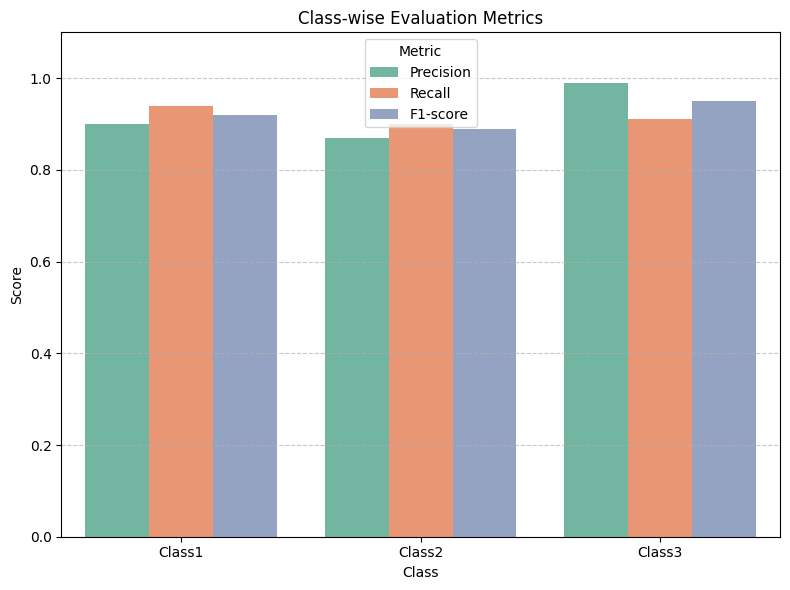

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define class-wise metrics from your report
metrics_data = {
    'Class': ['Class1', 'Class2', 'Class3'],
    'Precision': [0.90, 0.87, 0.99],
    'Recall':    [0.94, 0.90, 0.91],
    'F1-score':  [0.92, 0.89, 0.95]
}

# Create a DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Reshape for seaborn (long format)
df_long = df_metrics.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_long, x='Class', y='Score', hue='Metric', palette='Set2')

# Aesthetics
plt.title('Class-wise Evaluation Metrics')
plt.ylim(0.0, 1.1)
plt.ylabel('Score')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**5-Fold Cross-Validation Accuracy Overview**
This plot summarizes validation accuracy across the 5 cross-validation folds:

Black dots show the individual fold accuracies.

The blue point with error bar represents the mean ± standard deviation, indicating consistency in model performance.

This helps assess how well the model generalizes across different splits and identifies any significant variability between folds.

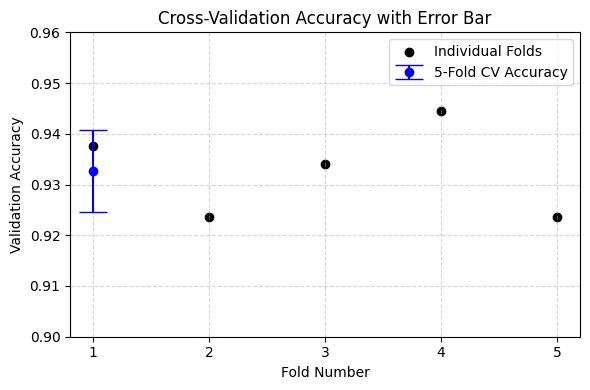

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fold_accuracies = [0.9375, 0.9236, 0.9340, 0.9444, 0.9236]
mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)

# Plot
plt.figure(figsize=(6, 4))
plt.errorbar(x=[1], y=[mean_acc], yerr=[std_acc], fmt='o', capsize=10, color='blue', label='5-Fold CV Accuracy')
plt.scatter(range(1, 6), fold_accuracies, color='black', label='Individual Folds')
plt.ylim(0.9, 0.96)
plt.ylabel('Validation Accuracy')
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Fold Number')
plt.title('Cross-Validation Accuracy with Error Bar')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **Ablation Studies**

In [ ]:
!pip install tensorflow albumentations scikit-learn opencv-python


# **1. Only using the baseline model.**

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4997 - loss: 1.3673

36/36 ━━━━━━━━━━━━━━━━━━━━ 78s 296ms/step - accuracy: 0.5018 - loss: 1.3635 - val_accuracy: 0.7882 - val_loss: 0.8731
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7465 - loss: 0.9115 - val_accuracy: 0.7500 - val_loss: 0.8809
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7948 - loss: 0.8544

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.7953 - loss: 0.8526 - val_accuracy: 0.8299 - val_loss: 0.8289
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7837 - loss: 0.8758

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.7840 - loss: 0.8750 - val_accuracy: 0.8472 - val_loss: 0.7609
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8885 - loss: 0.6498

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8890 - loss: 0.6484 - val_accuracy: 0.9167 - val_loss: 0.5960
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9450 - loss: 0.5007

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9451 - loss: 0.5006 - val_accuracy: 0.9236 - val_loss: 0.5954
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9550 - loss: 0.4803 - val_accuracy: 0.8090 - val_loss: 0.8187
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.8970 - loss: 0.6018 - val_accuracy: 0.9167 - val_loss: 0.5678
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9546 - loss: 0.4410 - val_accuracy: 0.8958 - val_loss: 0.6485
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9739 - loss: 0.3777 - val_accuracy: 0.9167 - val_loss: 0.6229
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9879 - loss: 0.3492 - val_accuracy: 0.9167 - val_loss: 0.6112
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9859 - loss: 0.3438 - val_accuracy: 0.9167 - val_loss: 0.6009
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9860 - loss: 0.3557 - val_accuracy: 0.8819 - 

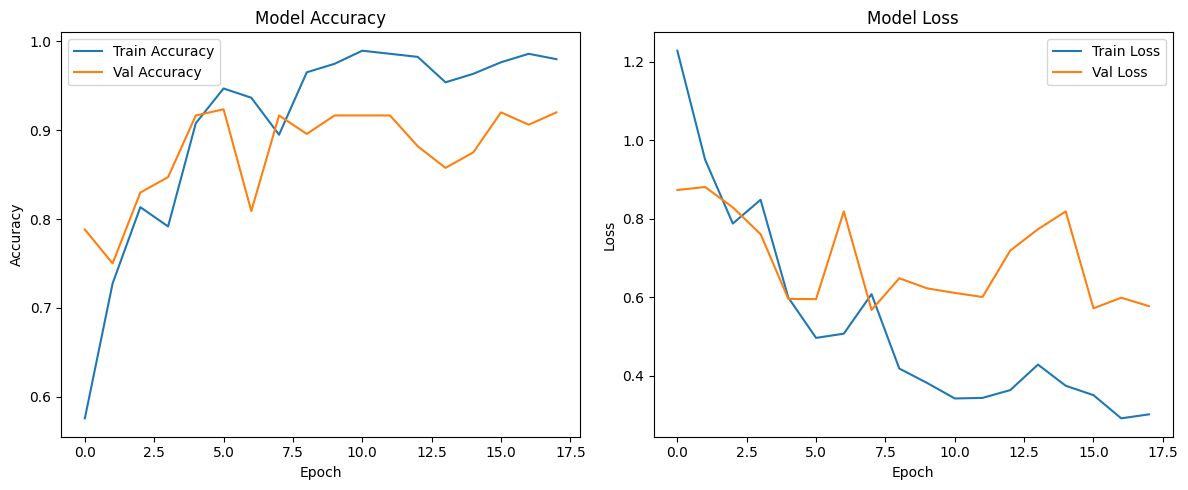

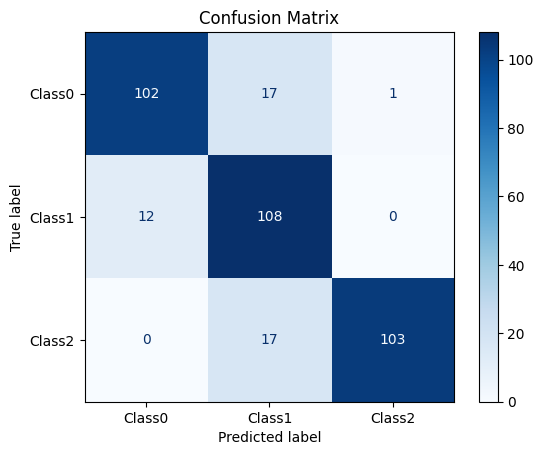

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2
import albumentations as A
import cv2

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

best_hp = {
    "init_lr": 0.0003930434735585379,
    "wd": 1.8392558832968022e-05,
    "d1": 0.42122483550873685,
    "d2": 0.16436263855893496,
    "fds": 7,
    "l2": 0.000998442519555421,
}

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4),
    A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

# Data Loaders
tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# Model (Baseline: ConvNeXtTiny without attention blocks)
def build_baseline_model(hp):
    base = ConvNeXtTiny(include_top=False, weights='imagenet',
                        input_shape=(*IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, 'relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, 'softmax')(x)
    model = Model(base.input, out)
    sched = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    model.compile(AdamW(sched, weight_decay=hp["wd"]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_baseline_model(best_hp)

# Train
history = model.fit(tr_ds, validation_data=va_ds,
                    epochs=EPOCHS,
                    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                               ModelCheckpoint("baseline_model.h5", "val_accuracy",
                                               save_best_only=True, mode="max")],
                    verbose=1)

# Evaluate on Test Set
model.load_weights("baseline_model.h5")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Display classification report in a table
print(pd.DataFrame(report).T)


# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# **2. Baseline model + CBAM**

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4276 - loss: 1.3980

36/36 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.4299 - loss: 1.3956 - val_accuracy: 0.6597 - val_loss: 1.0660
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6700 - loss: 1.0493

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.6705 - loss: 1.0484 - val_accuracy: 0.8229 - val_loss: 0.7932
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8083 - loss: 0.7847

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8087 - loss: 0.7836 - val_accuracy: 0.8715 - val_loss: 0.6493
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8149 - loss: 0.7366

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8158 - loss: 0.7350 - val_accuracy: 0.9028 - val_loss: 0.5683
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9203 - loss: 0.5425

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9201 - loss: 0.5426 - val_accuracy: 0.9097 - val_loss: 0.5238
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9452 - loss: 0.4503

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.9453 - loss: 0.4501 - val_accuracy: 0.9271 - val_loss: 0.5129
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9207 - loss: 0.5069 - val_accuracy: 0.9028 - val_loss: 0.5500
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9284 - loss: 0.4566 - val_accuracy: 0.9271 - val_loss: 0.4764
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9605 - loss: 0.3559 - val_accuracy: 0.8993 - val_loss: 0.5551
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9718 - loss: 0.3212

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.9720 - loss: 0.3207 - val_accuracy: 0.9306 - val_loss: 0.4831
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9911 - loss: 0.2586 - val_accuracy: 0.8993 - val_loss: 0.5305
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9875 - loss: 0.2596 - val_accuracy: 0.9236 - val_loss: 0.4861
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9835 - loss: 0.2751 - val_accuracy: 0.9306 - val_loss: 0.4553
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9693 - loss: 0.2980 - val_accuracy: 0.9306 - val_loss: 0.4362
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9779 - loss: 0.2564 - val_accuracy: 0.9028 - val_loss: 0.5359
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9625 - loss: 0.2524 - val_accuracy: 0.9062 - val_loss: 0.5701
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9582 - loss: 0.2504 - val_accuracy: 0.9271

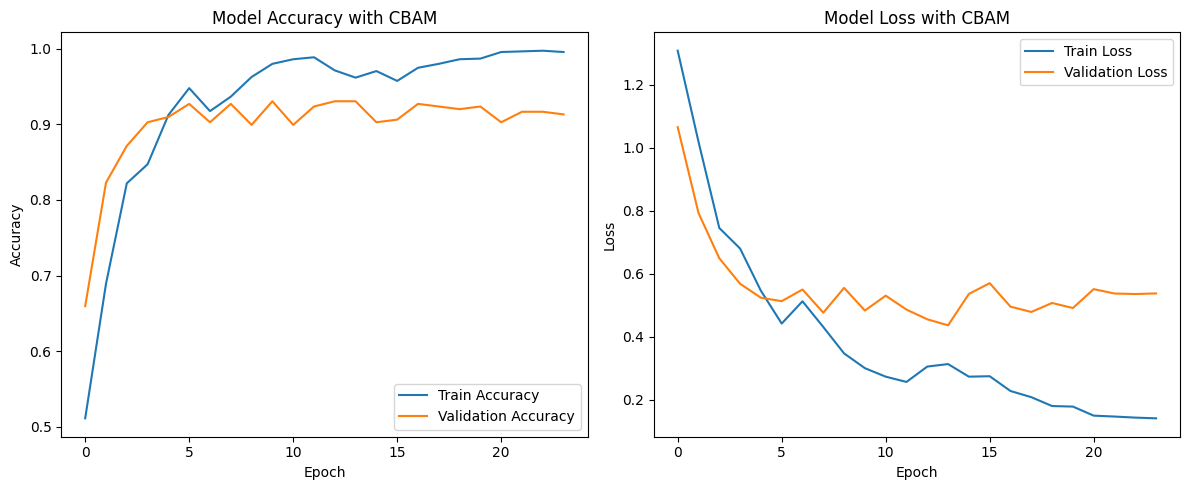

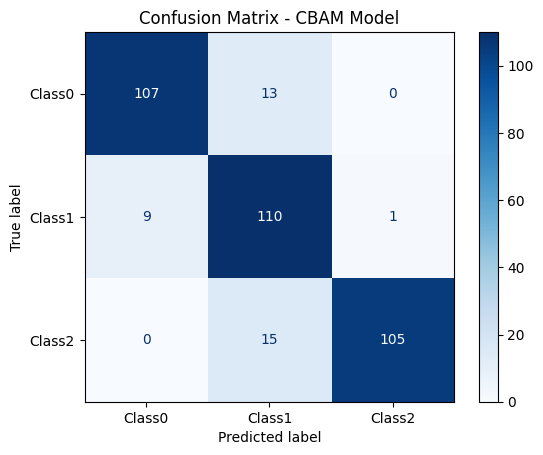

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D, Reshape, Activation, Multiply, Add, Conv2D, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2
import albumentations as A
import cv2

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

best_hp = {
    "init_lr": 0.0003930434735585379,
    "wd": 1.8392558832968022e-05,
    "d1": 0.42122483550873685,
    "d2": 0.16436263855893496,
    "fds": 7,
    "l2": 0.000998442519555421,
}

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4),
    A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

# Data Loaders
tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# CBAM Block
def cbam_block(x, ratio=8):
    ch = x.shape[-1]
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense_1 = Dense(ch // ratio, activation='relu')
    shared_dense_2 = Dense(ch)

    mlp_avg = shared_dense_2(shared_dense_1(avg_pool))
    mlp_max = shared_dense_2(shared_dense_1(max_pool))
    cbam_feature = Add()([mlp_avg, mlp_max])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Multiply()([x, Reshape((1, 1, ch))(cbam_feature)])

    avg_pool_spatial = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(cbam_feature)
    max_pool_spatial = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([cbam_feature, spatial_attention])
    return refined_feature

# Model with CBAM
def build_cbam_model(hp):
    base = ConvNeXtTiny(include_top=False, weights='imagenet',
                        input_shape=(*IMG_SIZE, 3))
    x = cbam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(base.input, out)
    lr_schedule = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    model.compile(AdamW(lr_schedule, weight_decay=hp["wd"]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train Model
model = build_cbam_model(best_hp)
history = model.fit(tr_ds, validation_data=va_ds,
                    epochs=EPOCHS,
                    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                               ModelCheckpoint("cbam_model.h5", "val_accuracy", save_best_only=True, mode="max")],
                    verbose=1)

# Evaluate on Test Set
model.load_weights("cbam_model.h5")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)

# Display Classification Report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print("\nClassification Report:")
print(pd.DataFrame(report).T)

# Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with CBAM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with CBAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CBAM Model")
plt.show()


# **3. Baseline model + MSAM**

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4792 - loss: 1.3840

36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 299ms/step - accuracy: 0.4809 - loss: 1.3813 - val_accuracy: 0.7639 - val_loss: 0.9233
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7201 - loss: 0.9533

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.7204 - loss: 0.9528 - val_accuracy: 0.7812 - val_loss: 0.8059
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8190 - loss: 0.7729

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8190 - loss: 0.7728 - val_accuracy: 0.8576 - val_loss: 0.7013
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8110 - loss: 0.7336

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.8112 - loss: 0.7335 - val_accuracy: 0.8854 - val_loss: 0.5839
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9083 - loss: 0.5625

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.9086 - loss: 0.5616 - val_accuracy: 0.9062 - val_loss: 0.5313
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9536 - loss: 0.4258

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9533 - loss: 0.4265 - val_accuracy: 0.9201 - val_loss: 0.5152
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9188 - loss: 0.5207 - val_accuracy: 0.9028 - val_loss: 0.5353
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9519 - loss: 0.4063 - val_accuracy: 0.8889 - val_loss: 0.5740
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9349 - loss: 0.4113 - val_accuracy: 0.9201 - val_loss: 0.5026
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9756 - loss: 0.3008 - val_accuracy: 0.9132 - val_loss: 0.4856
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9822 - loss: 0.2816

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9823 - loss: 0.2816 - val_accuracy: 0.9236 - val_loss: 0.4757
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9932 - loss: 0.2500 - val_accuracy: 0.9201 - val_loss: 0.4925
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9928 - loss: 0.2528 - val_accuracy: 0.9201 - val_loss: 0.4904
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9637 - loss: 0.2944 - val_accuracy: 0.8993 - val_loss: 0.5530
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9647 - loss: 0.3028 - val_accuracy: 0.8924 - val_loss: 0.5030
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9722 - loss: 0.2703 - val_accuracy: 0.9028 - val_loss: 0.5233
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9674 - loss: 0.2554 - val_accuracy: 0.9201 - val_loss: 0.4671
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9845 - loss: 0.2253 - val_accuracy: 0.9097

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9923 - loss: 0.1781 - val_accuracy: 0.9375 - val_loss: 0.5188
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9947 - loss: 0.1700 - val_accuracy: 0.9271 - val_loss: 0.5252
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9909 - loss: 0.1677 - val_accuracy: 0.9236 - val_loss: 0.5110
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9935 - loss: 0.1607 - val_accuracy: 0.9201 - val_loss: 0.5368
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9998 - loss: 0.1505 - val_accuracy: 0.9271 - val_loss: 0.5098
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9987 - loss: 0.1520 - val_accuracy: 0.9271 - val_loss: 0.5106
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9982 - loss: 0.1517 - val_accuracy: 0.9236 - val_loss: 0.5337
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9970 - loss: 0.1485 - val_accuracy: 0.9062

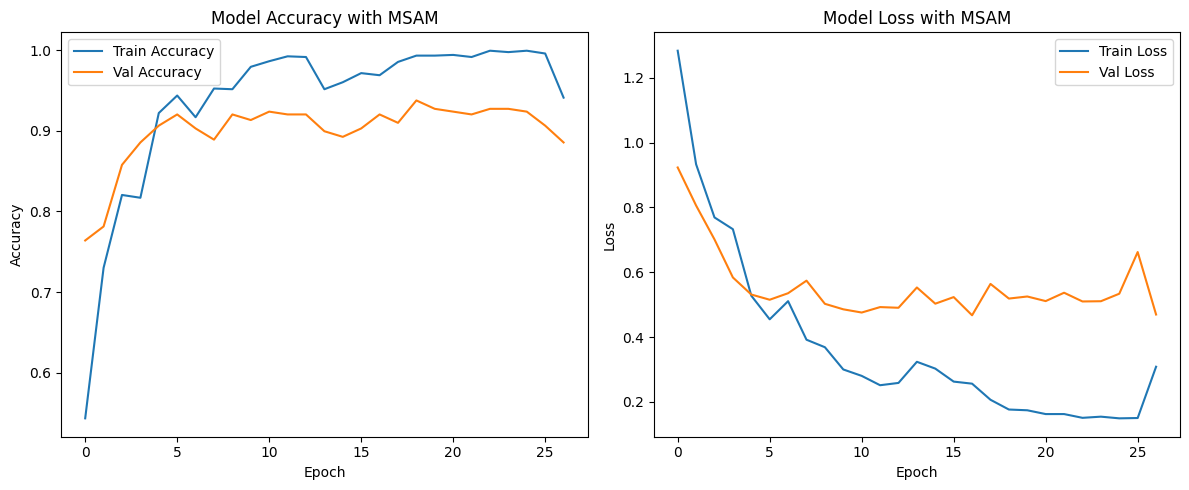

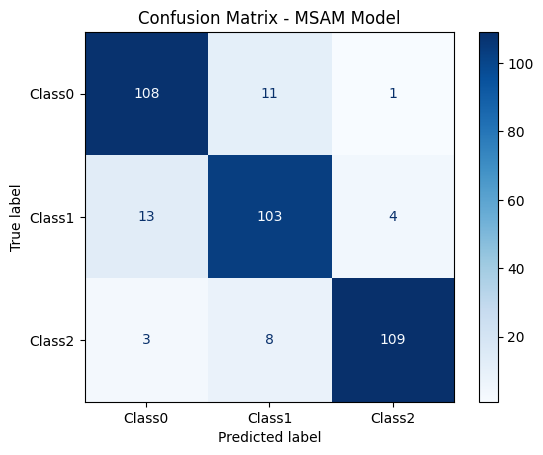

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D, Multiply, Reshape, Add, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

best_hp = {
    "init_lr": 0.0003930434735585379,
    "wd": 1.8392558832968022e-05,
    "d1": 0.42122483550873685,
    "d2": 0.16436263855893496,
    "fds": 7,
    "l2": 0.000998442519555421,
}

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4),
    A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

# Data Loaders
tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# MSAM block only
def msam_block(x):
    ch = x.shape[-1]
    gavg = GlobalAveragePooling2D()(x)
    gmax = GlobalMaxPooling2D()(x)
    summed = Add()([gavg, gmax])
    reshaped = Reshape((1, 1, ch))(summed)
    msam = Conv2D(ch, 1, activation='sigmoid')(reshaped)
    return Multiply()([x, msam])

# Build Model with MSAM block
def build_msam_model(hp):
    base = ConvNeXtTiny(include_top=False, weights='imagenet',
                        input_shape=(*IMG_SIZE, 3))
    x = msam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, 'relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, 'softmax')(x)
    model = Model(base.input, out)
    sched = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    model.compile(AdamW(sched, weight_decay=hp["wd"]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the model
model = build_msam_model(best_hp)
history = model.fit(tr_ds, validation_data=va_ds,
                    epochs=EPOCHS,
                    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                               ModelCheckpoint("msam_model.h5", "val_accuracy",
                                               save_best_only=True, mode="max")],
                    verbose=1)

# Evaluate on Test Set
model.load_weights("msam_model.h5")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Display classification report in a table
print(pd.DataFrame(report).T)

# Plot Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy with MSAM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss with MSAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MSAM Model")
plt.show()


# **4. Baseline model + CBAM + MSAM**

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4222 - loss: 0.5029

36/36 ━━━━━━━━━━━━━━━━━━━━ 83s 310ms/step - accuracy: 0.4250 - loss: 0.5018 - val_accuracy: 0.7951 - val_loss: 0.3508
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7265 - loss: 0.3481

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7267 - loss: 0.3477 - val_accuracy: 0.8368 - val_loss: 0.2753
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8353 - loss: 0.2679

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.8359 - loss: 0.2676 - val_accuracy: 0.8854 - val_loss: 0.2376
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8586 - loss: 0.2288

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8586 - loss: 0.2283 - val_accuracy: 0.9201 - val_loss: 0.1719
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9064 - loss: 0.1627

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9067 - loss: 0.1625 - val_accuracy: 0.9375 - val_loss: 0.1484
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9274 - loss: 0.1402 - val_accuracy: 0.9375 - val_loss: 0.1440
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9256 - loss: 0.1323 - val_accuracy: 0.9236 - val_loss: 0.1136
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9346 - loss: 0.0993 - val_accuracy: 0.8021 - val_loss: 0.1246
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9234 - loss: 0.0823 - val_accuracy: 0.9097 - val_loss: 0.0813
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9767 - loss: 0.0606

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9767 - loss: 0.0605 - val_accuracy: 0.9444 - val_loss: 0.0741
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9810 - loss: 0.0525 - val_accuracy: 0.9410 - val_loss: 0.0709
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9939 - loss: 0.0497 - val_accuracy: 0.9410 - val_loss: 0.0712
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9848 - loss: 0.0504 - val_accuracy: 0.9201 - val_loss: 0.0647
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9564 - loss: 0.0463 - val_accuracy: 0.9201 - val_loss: 0.0630
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9674 - loss: 0.0385 - val_accuracy: 0.9028 - val_loss: 0.0565
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9706 - loss: 0.0321 - val_accuracy: 0.8715 - val_loss: 0.0589
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9209 - loss: 0.0420 - val_accuracy: 0.9306

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9984 - loss: 0.0146 - val_accuracy: 0.9479 - val_loss: 0.0458
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9978 - loss: 0.0149 - val_accuracy: 0.9306 - val_loss: 0.0507
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9675 - loss: 0.0205 - val_accuracy: 0.9167 - val_loss: 0.0527
Epoch 27/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9749 - loss: 0.0175 - val_accuracy: 0.9028 - val_loss: 0.0375
Epoch 28/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9760 - loss: 0.0165 - val_accuracy: 0.9167 - val_loss: 0.0399
Epoch 29/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9800 - loss: 0.0159 - val_accuracy: 0.9201 - val_loss: 0.0517
Epoch 30/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9831 - loss: 0.0124 - val_accuracy: 0.9271 - val_loss: 0.0526
Epoch 31/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9832 - loss: 0.0111 - val_accuracy: 0.9236

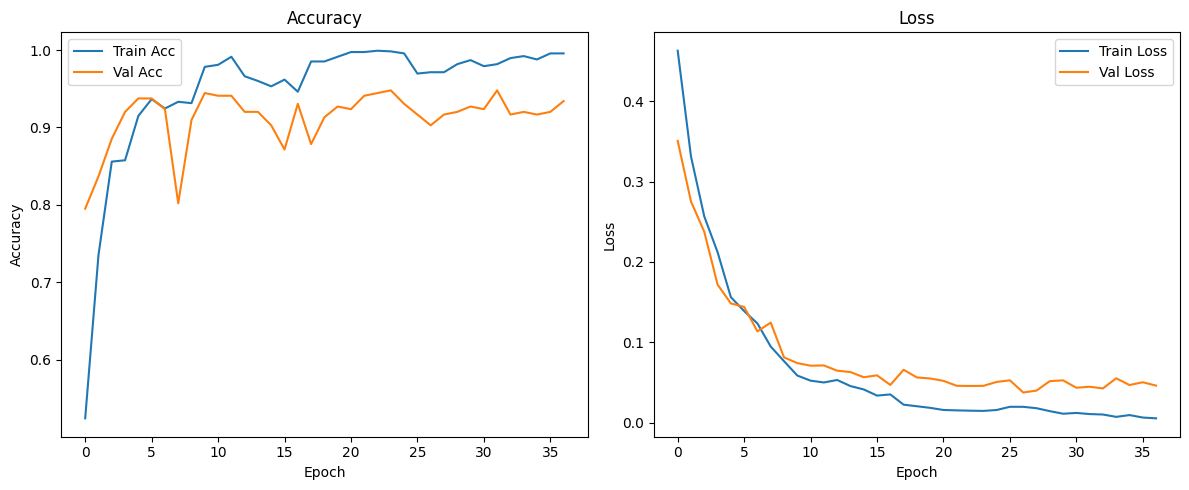

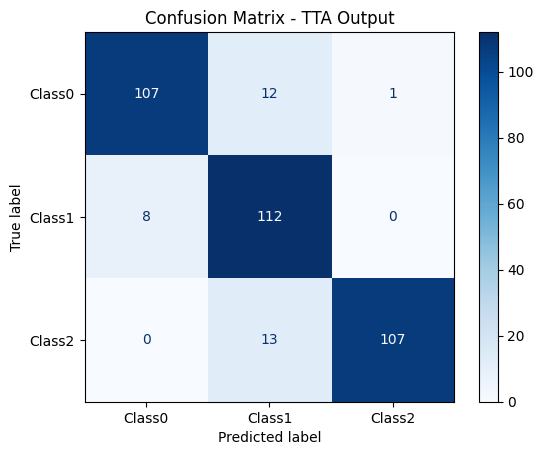

              precision    recall  f1-score  support
Class0         0.929204  0.875000  0.901288    120.0
Class1         0.800000  0.933333  0.861538    120.0
Class2         1.000000  0.891667  0.942731    120.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.909735  0.900000  0.901852    360.0
weighted avg   0.909735  0.900000  0.901852    360.0


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import albumentations as A
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Dropout,
                                     Conv2D, Multiply, Add, Concatenate, Activation, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.regularizers import l2

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

best_hp = {
    "init_lr": 0.0003930434735585379,
    "wd": 1.8392558832968022e-05,
    "d1": 0.42122483550873685,
    "d2": 0.16436263855893496,
    "fds": 7,
    "l2": 0.000998442519555421,
}

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4), A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

tta_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.2),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.2)
], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# CBAM + MSAM Block
def cbam_msam_block(x, ratio=8):
    ch = x.shape[-1]
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense = [Dense(ch // ratio, activation='relu'), Dense(ch)]
    avg_out = shared_dense[1](shared_dense[0](avg_pool))
    max_out = shared_dense[1](shared_dense[0](max_pool))
    ch_att = Activation('sigmoid')(Add()([avg_out, max_out]))
    ch_att = Reshape((1, 1, ch))(ch_att)
    x1 = Multiply()([x, ch_att])
    avg_pool_spatial = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x1)
    max_pool_spatial = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x1)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    sp_att = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x2 = Multiply()([x1, sp_att])
    avg = GlobalAveragePooling2D()(x)
    max_ = GlobalMaxPooling2D()(x)
    msam_vec = Lambda(lambda z: z[0] + z[1])([avg, max_])
    msam_vec = Reshape((1, 1, ch))(msam_vec)
    msam_weight = Conv2D(ch, kernel_size=1, activation='sigmoid')(msam_vec)
    x_out = Multiply()([x2, msam_weight])
    return x_out

# Focal Loss
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=1.5, alpha=0.25, from_logits=False, **kw):
        super().__init__(**kw); self.g, self.a, self.logit = gamma, alpha, from_logits
    def call(self, y_true, y_pred):
        if self.logit: y_pred = tf.nn.softmax(y_pred, -1)
        eps = 1e-7; y_pred = tf.clip_by_value(y_pred, eps, 1 - eps)
        ce = -y_true * tf.math.log(y_pred)
        loss = self.a * tf.pow(1 - y_pred, self.g) * ce
        return tf.reduce_sum(loss, -1)

def build_model(hp):
    base = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    x = cbam_msam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(base.input, out)
    sched = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    model.compile(optimizer=AdamW(sched, weight_decay=hp["wd"]),
                  loss=FocalLoss(), metrics=["accuracy"])
    return model

model = build_model(best_hp)
callbacks = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint("cbam_msam_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
]

history = model.fit(tr_ds, validation_data=va_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)
model.load_weights("cbam_msam_model.h5")

# Evaluation
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T

# TTA
def predict_tta(model, rounds=5):
    preds = []
    for _ in range(rounds):
        ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
        ds = ds.map(lambda p, l: mapper(p, l, tta_tf), num_parallel_calls=tf.data.AUTOTUNE)
        preds.append(model.predict(ds.batch(BATCH_SIZE), verbose=0))
    return np.mean(preds, axis=0)

tta_preds = predict_tta(model, rounds=5)
y_pred_tta = np.argmax(tta_preds, axis=1)
tta_acc = accuracy_score(y_true, y_pred_tta)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_tta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - TTA Output")
plt.show()

print(report_df)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,
                                     Conv2D, Multiply, Add, Concatenate,
                                     Activation, Reshape, Lambda, GlobalMaxPooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# Example image size and number of classes
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

# Define your best hyperparameters (replace with your values)
best_hp = {
    "init_lr": 0.000393,
    "wd": 1.839e-05,
    "d1": 0.42,
    "d2": 0.16,
    "fds": 7,
    "l2": 0.000998,
}

# ─── CBAM + MSAM Block ─────────────────────────────
def cbam_msam_block(x, ratio=8):
    ch = x.shape[-1]

    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    shared_dense = [Dense(ch // ratio, activation='relu'), Dense(ch)]

    avg_out = shared_dense[1](shared_dense[0](avg_pool))
    max_out = shared_dense[1](shared_dense[0](max_pool))
    ch_att = Activation('sigmoid')(Add()([avg_out, max_out]))
    ch_att = Reshape((1, 1, ch))(ch_att)
    x1 = Multiply()([x, ch_att])

    avg_pool_spatial = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x1)
    max_pool_spatial = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x1)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    sp_att = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x2 = Multiply()([x1, sp_att])

    avg = GlobalAveragePooling2D()(x)
    max_ = GlobalMaxPooling2D()(x)
    msam_vec = Lambda(lambda z: z[0] + z[1])([avg, max_])
    msam_vec = Reshape((1, 1, ch))(msam_vec)
    msam_weight = Conv2D(ch, kernel_size=1, activation='sigmoid')(msam_vec)

    return Multiply()([x2, msam_weight])

# ─── Model Builder ─────────────────────────────
def build_model(hp):
    base = ConvNeXtTiny(include_top=False, weights="imagenet", input_shape=(*IMG_SIZE, 3))
    x = cbam_msam_block(base.output)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp["d1"])(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["d2"])(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=out)
    sched = CosineDecayRestarts(hp["init_lr"], hp["fds"], t_mul=2.0, m_mul=1.0)
    model.compile(optimizer=AdamW(sched, weight_decay=hp["wd"]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ─── Build the model and inspect layers ─────────────────────
model = build_model(best_hp)

print("\n🔍 All Model Layers with Output Shapes:")
for i, layer in enumerate(model.layers):
    print(f"{i:03d}: {layer.name:<55} {layer.output.shape}")



🔍 All Model Layers with Output Shapes:
000: input_layer_5                                           (None, 224, 224, 3)
001: convnext_tiny_prestem_normalization                     (None, 224, 224, 3)
002: convnext_tiny_stem                                      (None, 56, 56, 96)
003: convnext_tiny_stage_0_block_0_depthwise_conv            (None, 56, 56, 96)
004: convnext_tiny_stage_0_block_0_layernorm                 (None, 56, 56, 96)
005: convnext_tiny_stage_0_block_0_pointwise_conv_1          (None, 56, 56, 384)
006: convnext_tiny_stage_0_block_0_gelu                      (None, 56, 56, 384)
007: convnext_tiny_stage_0_block_0_pointwise_conv_2          (None, 56, 56, 96)
008: convnext_tiny_stage_0_block_0_layer_scale               (None, 56, 56, 96)
009: convnext_tiny_stage_0_block_0_identity                  (None, 56, 56, 96)
010: convnext_tiny_stage_0_block_1_depthwise_conv            (None, 56, 56, 96)
011: convnext_tiny_stage_0_block_1_layernorm                 (None, 56, 56, 

# **Comparison with the state-of-the-art models**

Epoch 1/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5022 - loss: 1.2207

36/36 ━━━━━━━━━━━━━━━━━━━━ 63s 232ms/step - accuracy: 0.5085 - loss: 1.2045 - val_accuracy: 0.7951 - val_loss: 0.5911
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8112 - loss: 0.5044 - val_accuracy: 0.7812 - val_loss: 0.9188
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8683 - loss: 0.3958 - val_accuracy: 0.7951 - val_loss: 0.8898
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8871 - loss: 0.3222 - val_accuracy: 0.8021 - val_loss: 1.0117
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9230 - loss: 0.2429 - val_accuracy: 0.8368 - val_loss: 0.6477
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9368 - loss: 0.2288

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9369 - loss: 0.2286 - val_accuracy: 0.8576 - val_loss: 0.4973
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9457 - loss: 0.1831 - val_accuracy: 0.8368 - val_loss: 0.8164
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9537 - loss: 0.1641 - val_accuracy: 0.8403 - val_loss: 0.8621
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9754 - loss: 0.1168 - val_accuracy: 0.8472 - val_loss: 0.8253
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9562 - loss: 0.1680 - val_accuracy: 0.7535 - val_loss: 1.0192
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9567 - loss: 0.1450 - val_accuracy: 0.7882 - val_loss: 0.9182
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9692 - loss: 0.1488

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.9692 - loss: 0.1485 - val_accuracy: 0.8819 - val_loss: 0.4492
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9833 - loss: 0.1146

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.9831 - loss: 0.1147 - val_accuracy: 0.9236 - val_loss: 0.4182
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9690 - loss: 0.1428

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9690 - loss: 0.1425 - val_accuracy: 0.9132 - val_loss: 0.4018
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9884 - loss: 0.0955 - val_accuracy: 0.9062 - val_loss: 0.5380
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9731 - loss: 0.1129 - val_accuracy: 0.9062 - val_loss: 0.4730
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9828 - loss: 0.1220 - val_accuracy: 0.8264 - val_loss: 0.6004
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9680 - loss: 0.1291 - val_accuracy: 0.8750 - val_loss: 0.4283
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9585 - loss: 0.1607

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.9588 - loss: 0.1600 - val_accuracy: 0.9201 - val_loss: 0.3724
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9810 - loss: 0.0997 - val_accuracy: 0.8715 - val_loss: 0.5662
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9845 - loss: 0.1059 - val_accuracy: 0.8854 - val_loss: 0.5071
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9603 - loss: 0.1358 - val_accuracy: 0.8889 - val_loss: 0.5677
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9805 - loss: 0.0988 - val_accuracy: 0.8889 - val_loss: 0.5017
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9895 - loss: 0.0751 - val_accuracy: 0.9236 - val_loss: 0.4077
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9802 - loss: 0.0894 - val_accuracy: 0.8924 - val_loss: 0.4281
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9854 - loss: 0.0853 - val_accuracy: 0.8993 - val_

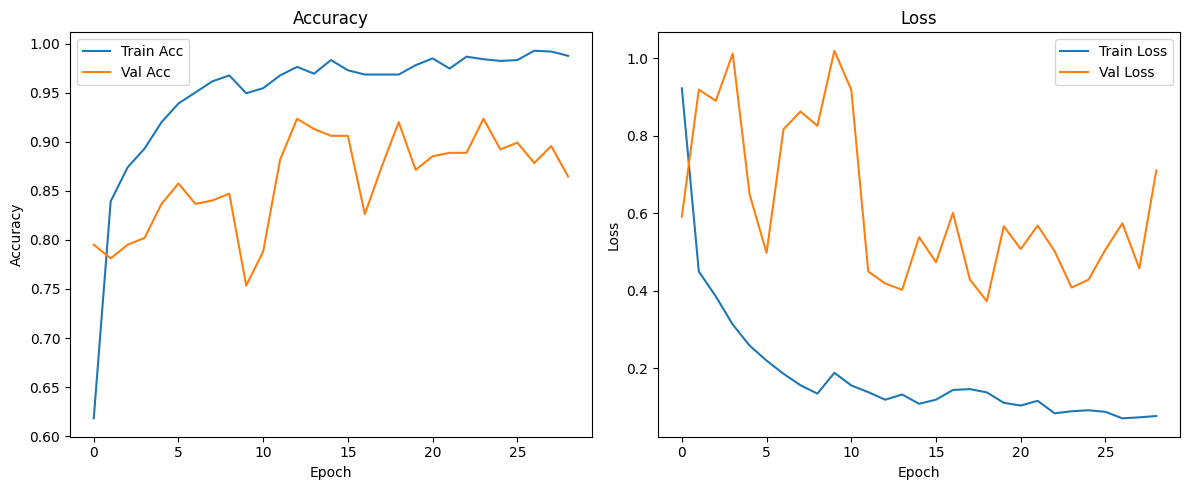

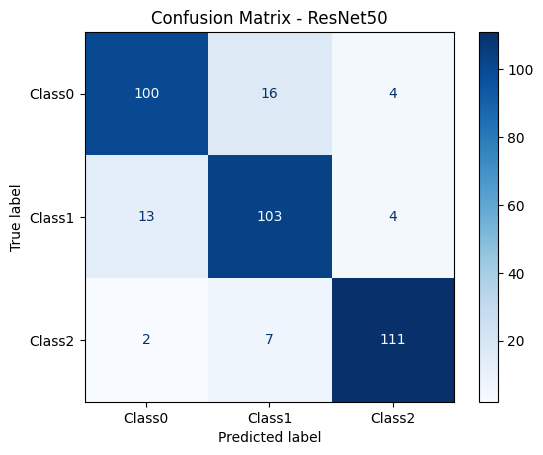

,Class0,Class1,Class2,accuracy,macro avg,weighted avg
precision,0.869565,0.817460,0.932773,0.872222,0.873266,0.873266
recall,0.833333,0.858333,0.925000,0.872222,0.872222,0.872222
f1-score,0.851064,0.837398,0.928870,0.872222,0.872444,0.872444
support,120.000000,120.000000,120.000000,0.872222,360.000000,360.000000


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import albumentations as A

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42
NUM_CLASSES = 3

# Sample dataset paths (adjust to actual paths if running locally)
TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4),
    A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([NUM_CLASSES])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# Build ResNet50 model
def build_resnet_model():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_resnet_model()

history = model.fit(tr_ds, validation_data=va_ds,
                    epochs=EPOCHS,
                    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                               ModelCheckpoint("resnet_model.h5", save_best_only=True)],
                    verbose=1)

# Evaluate
model.load_weights("resnet_model.h5")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=labels, output_dict=True))

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ResNet50")
plt.show()

report_df


# **EfficientNetB0**

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3693 - loss: 1.1672

36/36 ━━━━━━━━━━━━━━━━━━━━ 157s 543ms/step - accuracy: 0.3711 - loss: 1.1654 - val_accuracy: 0.4965 - val_loss: 1.0464
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6640 - loss: 0.8524

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6644 - loss: 0.8511 - val_accuracy: 0.5660 - val_loss: 0.8816
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7513 - loss: 0.6441

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7513 - loss: 0.6434 - val_accuracy: 0.7257 - val_loss: 0.7061
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8090 - loss: 0.5029

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8086 - loss: 0.5033 - val_accuracy: 0.8021 - val_loss: 0.5587
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8157 - loss: 0.4579

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8160 - loss: 0.4578 - val_accuracy: 0.8333 - val_loss: 0.4776
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8609 - loss: 0.3858

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8605 - loss: 0.3865 - val_accuracy: 0.8368 - val_loss: 0.4365
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8813 - loss: 0.3626

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.8815 - loss: 0.3622 - val_accuracy: 0.8819 - val_loss: 0.3818
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8909 - loss: 0.3172

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.8906 - loss: 0.3176 - val_accuracy: 0.8889 - val_loss: 0.3586
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9062 - loss: 0.2686 - val_accuracy: 0.8889 - val_loss: 0.3634
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9258 - loss: 0.2376 - val_accuracy: 0.8854 - val_loss: 0.3556
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9457 - loss: 0.2066

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9453 - loss: 0.2074 - val_accuracy: 0.8924 - val_loss: 0.3399
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9378 - loss: 0.2137 - val_accuracy: 0.8854 - val_loss: 0.3578
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9392 - loss: 0.2018 - val_accuracy: 0.8924 - val_loss: 0.3368
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9369 - loss: 0.2005 - val_accuracy: 0.8819 - val_loss: 0.3719
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9623 - loss: 0.1582

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9619 - loss: 0.1586 - val_accuracy: 0.9028 - val_loss: 0.3891
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9595 - loss: 0.1459

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9595 - loss: 0.1458 - val_accuracy: 0.9097 - val_loss: 0.4005
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9660 - loss: 0.1402 - val_accuracy: 0.8854 - val_loss: 0.4470
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9708 - loss: 0.1251 - val_accuracy: 0.9097 - val_loss: 0.4131
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9669 - loss: 0.1261 - val_accuracy: 0.9028 - val_loss: 0.4446
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9602 - loss: 0.1300 - val_accuracy: 0.9097 - val_loss: 0.4122
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9795 - loss: 0.1108

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9796 - loss: 0.1107 - val_accuracy: 0.9167 - val_loss: 0.4056
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9742 - loss: 0.1148 - val_accuracy: 0.9062 - val_loss: 0.4118
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9643 - loss: 0.1382 - val_accuracy: 0.9097 - val_loss: 0.4389
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 622ms/step
              precision    recall  f1-score     support
Class0         0.884298  0.891667  0.887967  120.000000
Class1         0.819549  0.908333  0.861660  120.000000
Class2         0.990566  0.875000  0.929204  120.000000
accuracy       0.891667  0.891667  0.891667    0.891667
macro avg      0.898137  0.891667  0.892943  360.000000
weighted avg   0.898137  0.891667  0.892943  360.000000


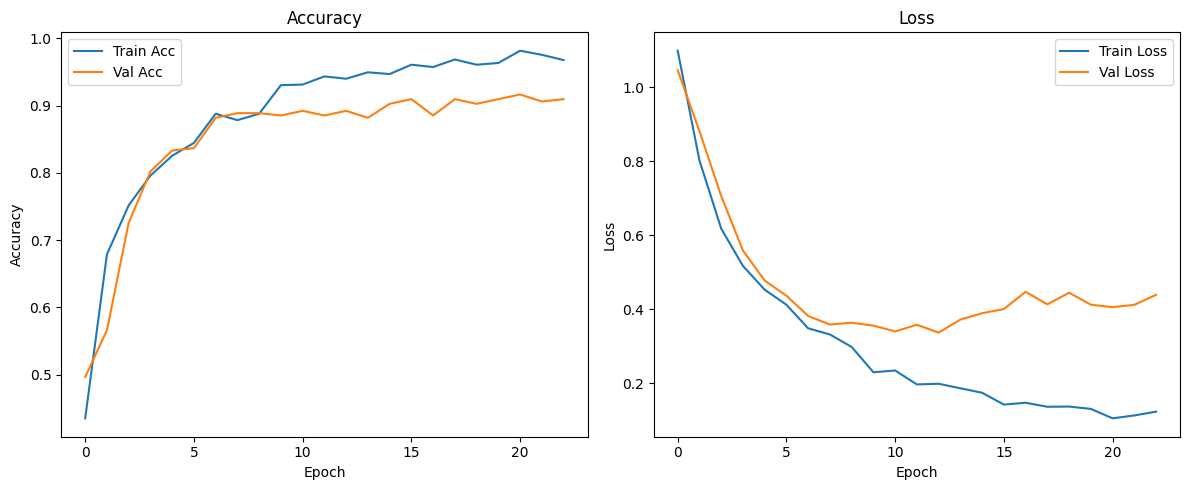

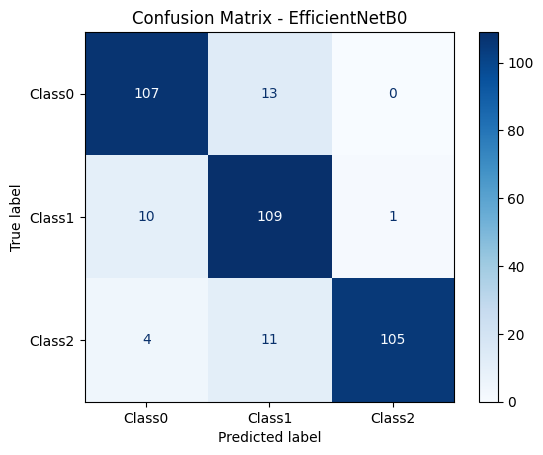

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import albumentations as A
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

# Hyperparameters
hp = {
    "lr": 1e-4,
    "dropout1": 0.3,
    "dropout2": 0.2,
    "l2": 1e-4,
}

# Albumentations
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4), A.GaussianBlur((3, 5), p=0.3)
])
val_tf = A.Compose([A.Resize(*IMG_SIZE)])

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# Model
def build_efficientnet_model(hp):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(hp["dropout1"])(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(hp["l2"]))(x)
    x = Dropout(hp["dropout2"])(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(hp["lr"]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_efficientnet_model(hp)
callbacks = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint("efficientnetb0_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")
]

history = model.fit(tr_ds, validation_data=va_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)
model.load_weights("efficientnetb0_model.h5")

# Evaluate
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print(pd.DataFrame(report).T)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout(); plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - EfficientNetB0")
plt.show()


# **DenseNet121**

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4445 - loss: 1.2760

36/36 ━━━━━━━━━━━━━━━━━━━━ 175s 481ms/step - accuracy: 0.4472 - loss: 1.2699 - val_accuracy: 0.6944 - val_loss: 0.6678
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7239 - loss: 0.6789

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.7244 - loss: 0.6774 - val_accuracy: 0.7361 - val_loss: 0.5960
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7980 - loss: 0.4665

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7983 - loss: 0.4664 - val_accuracy: 0.7812 - val_loss: 0.5234
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8526 - loss: 0.3466

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.8525 - loss: 0.3465 - val_accuracy: 0.8681 - val_loss: 0.3503
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8829 - loss: 0.3000

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.8826 - loss: 0.3008 - val_accuracy: 0.8889 - val_loss: 0.3069
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9082 - loss: 0.2608 - val_accuracy: 0.8715 - val_loss: 0.3233
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9239 - loss: 0.2017

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9235 - loss: 0.2025 - val_accuracy: 0.8924 - val_loss: 0.3032
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9384 - loss: 0.1675 - val_accuracy: 0.8646 - val_loss: 0.3655
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9209 - loss: 0.1963

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9209 - loss: 0.1963 - val_accuracy: 0.8993 - val_loss: 0.2819
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.9539 - loss: 0.1359 - val_accuracy: 0.8993 - val_loss: 0.2692
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9471 - loss: 0.1484

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9473 - loss: 0.1479 - val_accuracy: 0.9236 - val_loss: 0.2656
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9622 - loss: 0.1277 - val_accuracy: 0.9201 - val_loss: 0.2688
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9674 - loss: 0.0712 - val_accuracy: 0.9167 - val_loss: 0.2778
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9739 - loss: 0.0873

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9737 - loss: 0.0876 - val_accuracy: 0.9340 - val_loss: 0.2593
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9642 - loss: 0.1009 - val_accuracy: 0.8958 - val_loss: 0.3151
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9765 - loss: 0.0835 - val_accuracy: 0.8854 - val_loss: 0.2957
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9733 - loss: 0.0680 - val_accuracy: 0.8681 - val_loss: 0.3867
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9691 - loss: 0.0784 - val_accuracy: 0.8750 - val_loss: 0.4404
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9749 - loss: 0.0667 - val_accuracy: 0.8750 - val_loss: 0.5020
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9811 - loss: 0.0483 - val_accuracy: 0.8958 - val_loss: 0.3432
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9883 - loss: 0.0536 - val_accuracy: 0.9271 - val_

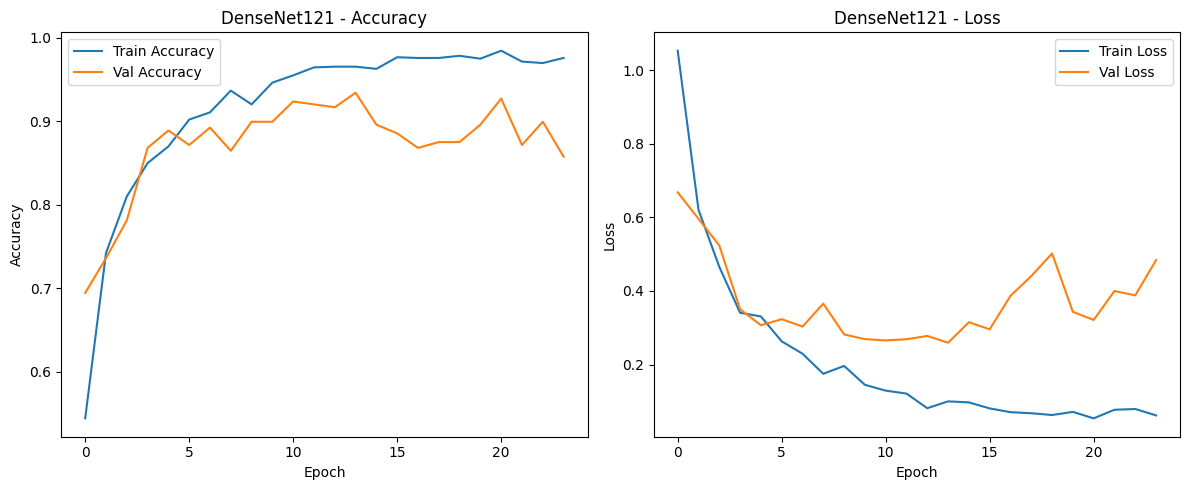

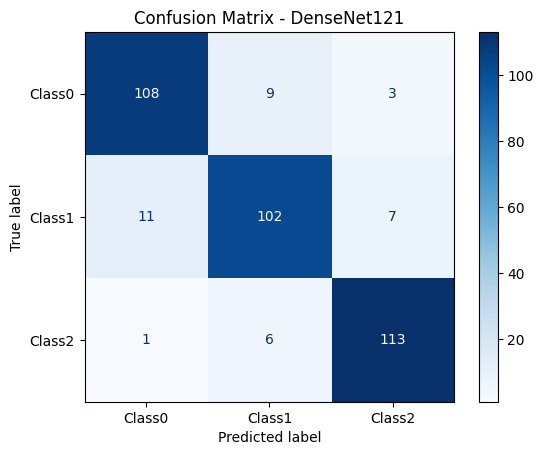

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import albumentations as A
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
PATIENCE = 10
SEED = 42

TRAIN_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Train")
TEST_DIR = Path("/content/drive/MyDrive/Data/PreprocessedData/Test")

# Albumentations Transforms
train_tf = A.Compose([
    A.Resize(*IMG_SIZE), A.HorizontalFlip(0.5), A.VerticalFlip(0.2),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.4),
    A.GaussianBlur((3, 5), p=0.3)
], p=1.0)

val_tf = A.Compose([A.Resize(*IMG_SIZE)], p=1.0)

def mapper(path, label, aug):
    def _parse(p, l):
        img = cv2.cvtColor(cv2.imread(p.decode()), cv2.COLOR_BGR2RGB)
        img = preprocess_input(aug(image=img)["image"])
        return img.astype(np.float32), l.astype(np.float32)
    img, lab = tf.numpy_function(_parse, [path, label], [tf.float32, tf.float32])
    img.set_shape([*IMG_SIZE, 3]); lab.set_shape([3])
    return img, lab

def make_ds(paths, labels, aug, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: mapper(x, y, aug), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def make_df(folder: Path):
    return pd.DataFrame([{"filepath": str(folder/c/f), "label": c}
                         for c in os.listdir(folder) for f in os.listdir(folder/c)])

df = make_df(TRAIN_DIR)
test = make_df(TEST_DIR)

labels = sorted(df.label.unique())
label_map = {c: i for i, c in enumerate(labels)}
NUM_CLASSES = len(labels)

def to_onehot(lbl):
    v = np.zeros(NUM_CLASSES, np.float32); v[label_map[lbl]] = 1; return v

df["oh"] = df.label.map(to_onehot)
test["oh"] = test.label.map(to_onehot)

X = df.filepath.values
y = np.stack(df.oh.values)
test_paths = test.filepath.values
test_labels = np.stack(test.oh.values)

# Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=df.label.values,
                                                  random_state=SEED)

# Data Loaders
tr_ds = make_ds(X_train, y_train, train_tf, shuffle=True)
va_ds = make_ds(X_val, y_val, val_tf)
test_ds = make_ds(test_paths, test_labels, val_tf)

# Build DenseNet121 Model
def build_densenet_model():
    base = DenseNet121(include_top=False, weights='imagenet',
                       input_shape=(*IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_densenet_model()

# Training
history = model.fit(tr_ds, validation_data=va_ds,
                    epochs=EPOCHS,
                    callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                               ModelCheckpoint("densenet_model.h5", "val_accuracy",
                                               save_best_only=True, mode="max")],
                    verbose=1)

# Evaluation
model.load_weights("densenet_model.h5")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
preds = model.predict(test_ds)
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(preds, axis=1)
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Display classification report
print(pd.DataFrame(report).T)

# Accuracy and Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('DenseNet121 - Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('DenseNet121 - Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - DenseNet121")
plt.show()


# **Blinded Peer Review - Dental Experts**

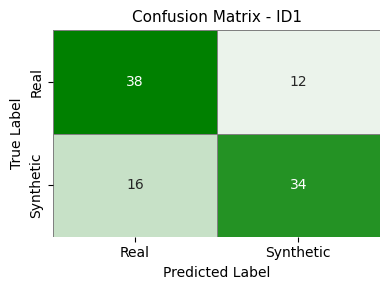

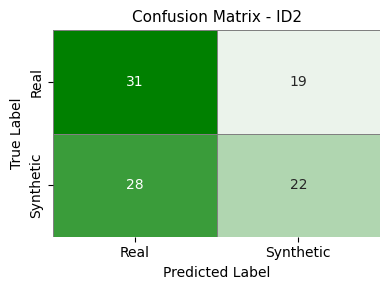

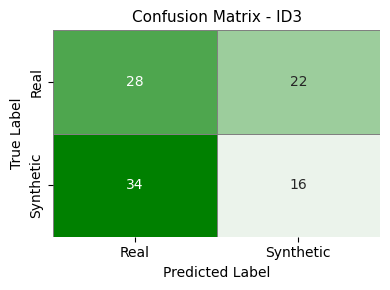

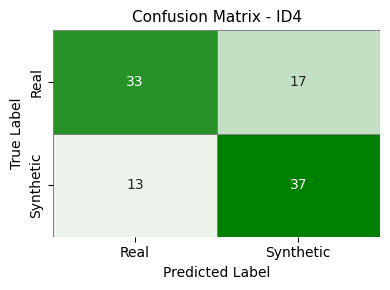

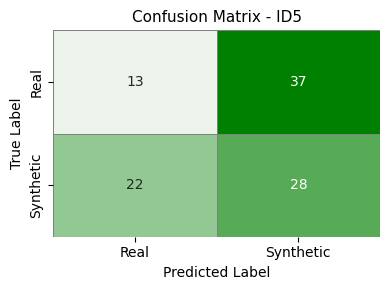

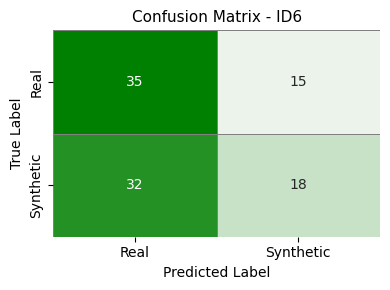

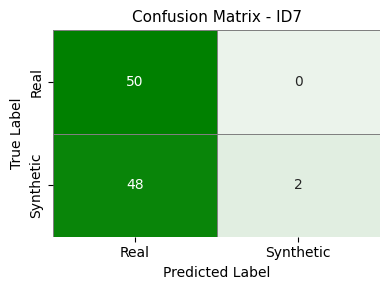

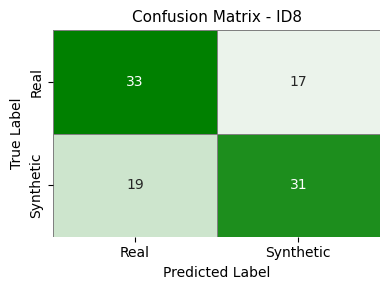

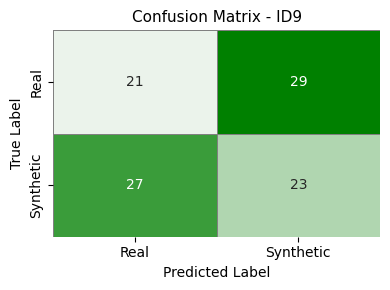

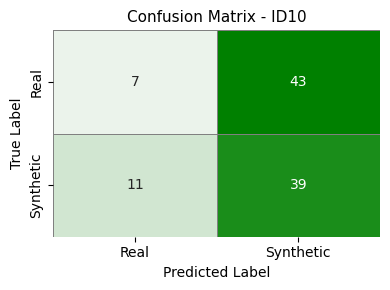

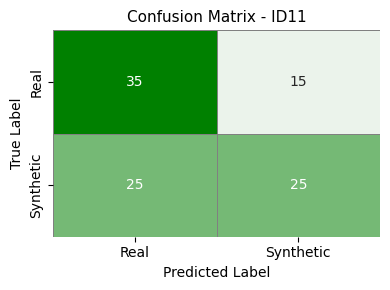

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your Excel file
df = pd.read_excel("/content/response.xlsx")  # Replace with your actual path

# Convert ground truth to string type
y_true = df["Label"].astype(str)

# Define binary class labels explicitly
class_labels = ["Real", "Synthetic"]

# Identify reviewer columns
reviewer_cols = [col for col in df.columns if col.startswith("ID")]

# Custom light color map (single pastel shade)
light_green_cmap = sns.light_palette("green", as_cmap=True)

# Loop through each reviewer and plot 2×2 confusion matrix
for col in reviewer_cols:
    y_pred = df[col].astype(str)

    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=light_green_cmap,
                xticklabels=class_labels, yticklabels=class_labels, cbar=False, linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted Label", fontsize=10)
    plt.ylabel("True Label", fontsize=10)
    plt.title(f"Confusion Matrix - {col}", fontsize=11)
    plt.tight_layout()
    plt.show()
